In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# Any results you write to the current directory are saved as output.

### ライブラリの読み込み

今回使用するライブラリを読み込みます。

In [122]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer

### データの読み込み

kaggleからデータセットをダウンロードして読み込みます。
また、学習データにどのようなカラムが存在するのかも見てみます。

In [123]:
#データの読み込み
train = pd.read_csv("train.csv")
test_x = pd.read_csv("test.csv")

#学習データの変数を確認
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

変数が80個近くあります、、
1個1個見ていくのはつらいものがあるので、以降では変数の説明は最低限にしてモデル作成を進めていきたいと思います。

## EDA（探索的データ分析）

まずは目的変数である「SalesPrice（家の購入価格）」について見ていきます。

In [124]:
#目的変数である家の価格の要約統計量を表示する
train["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

50パーセントタイルが16万なのに対して平均が18万となっている、かつMAXが75万と大きいので正規分布にはなってない気がします。ヒストグラムを見てみます。

/Users/shin/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


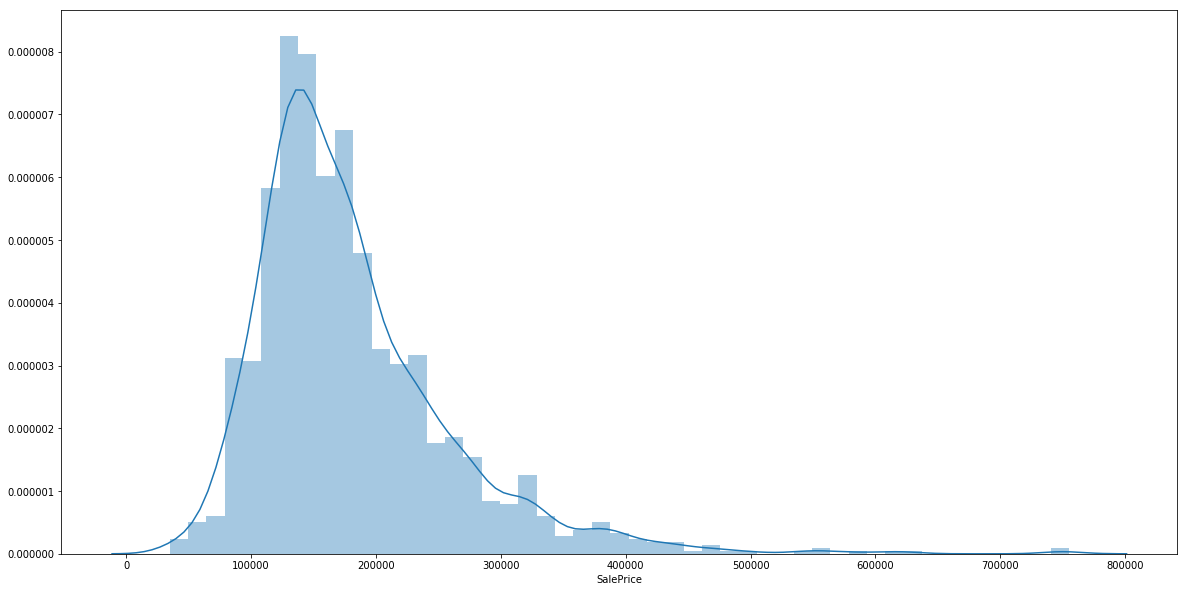

In [125]:
#目的変数である家の価格のヒストグラムを表示する
plt.figure(figsize=(20, 10))
sns.distplot(train['SalePrice'])

やはり正規分布になっていませんね。目的変数の分布は正規分布になっていないとモデルの予測精度に影響が出てしまうので、これはあとで対数変換する必要がありそうです。

正規分布からのずれを表す歪度と尖度を計算してみます。

In [126]:
#歪度と尖度を計算
print("歪度: %f" % train['SalePrice'].skew())
print("尖度: %f" % train['SalePrice'].kurt())

歪度: 1.882876
尖度: 6.536282


歪度が正の値なので、右裾が長い（≒左に偏っている）分布であること、さらに尖度が正の値のため正規分布よりもだいぶ尖った（平均付近にデータが集中している）分布であることあがわかります。

ここで常識的に考えてみると、

1. 物件の大きさ（広さ）
2. 築年数

あたりが物件の価格に影響しそうなので、目的変数との関係を見てみます。

### 物件の大きさ（広さ）

説明変数を見ると以下のものが物件の大きさを表しているようです。
* 1stFlrSF: 1階の広さ
* 2ndFlrSF: 2階の広さ
* TotalBsmtSF:地下の広さ

Text(0, 0.5, 'SalePrice')

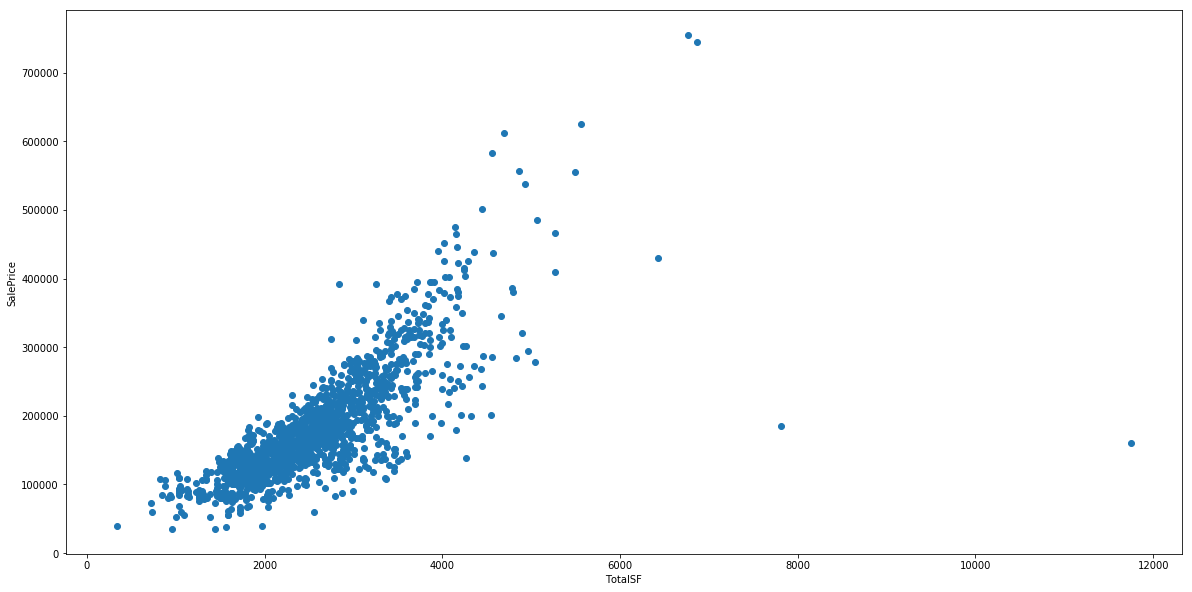

In [127]:
#物件の広さを合計した変数を作成
train["TotalSF"] = train["1stFlrSF"] + train["2ndFlrSF"] + train["TotalBsmtSF"]
test_x["TotalSF"] = test_x["1stFlrSF"] + test_x["2ndFlrSF"] + test_x["TotalBsmtSF"]

#合計した変数を削除
# train.drop(['1stFlrSF', '2ndFlrSF', 'TotalBsmtSF'], axis = 1, inplace = True)
# test_x.drop(['1stFlrSF', '2ndFlrSF', 'TotalBsmtSF'], axis = 1, inplace = True)

#物件の広さと物件価格の散布図を作成
plt.figure(figsize=(20, 10))
plt.scatter(train["TotalSF"],train["SalePrice"])
plt.xlabel("TotalSF")
plt.ylabel("SalePrice")

若干外れ値がありますが、相関しているように見えます。やはり物件が大きくなるほど物件価格も高くなることがわかります。<br>
外れ値は除外しておきます。

Text(0, 0.5, 'SalePrice')

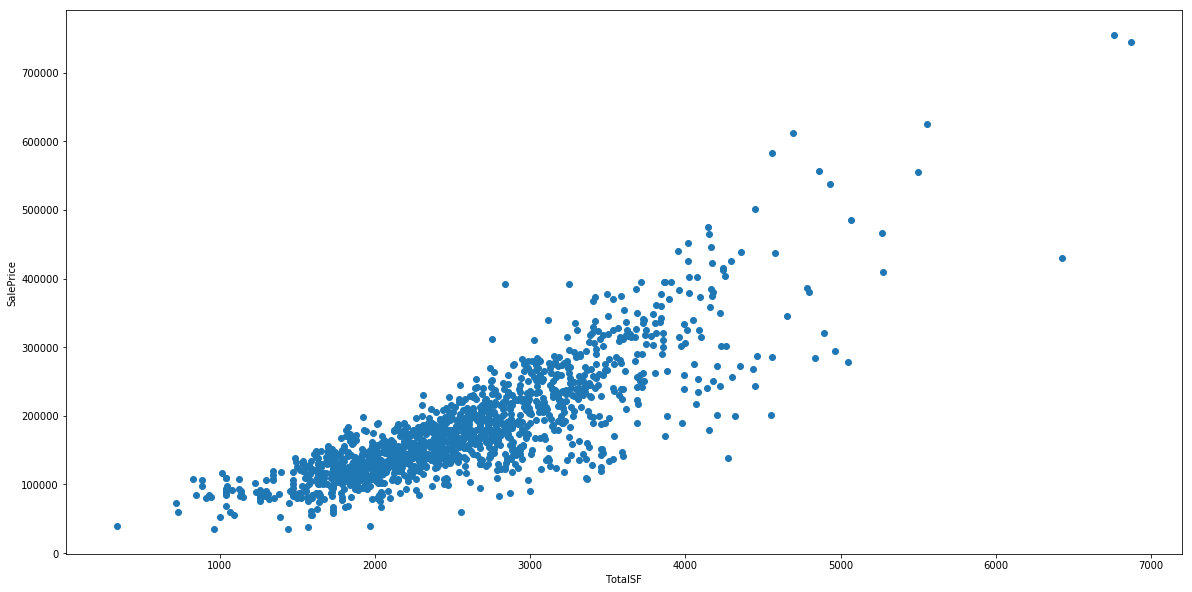

In [128]:
#外れ値を除外する
train = train.drop(train[(train['TotalSF']>7500) & (train['SalePrice']<300000)].index)

#物件の広さと物件価格の散布図を作成
plt.figure(figsize=(20, 10))
plt.scatter(train["TotalSF"],train["SalePrice"])
plt.xlabel("TotalSF")
plt.ylabel("SalePrice")

外れ値が除外できました。

### 築年数

続いて築年数です。説明変数を見ると以下のものが築年数を表しているようです。
* YearBuilt ： Original construction date

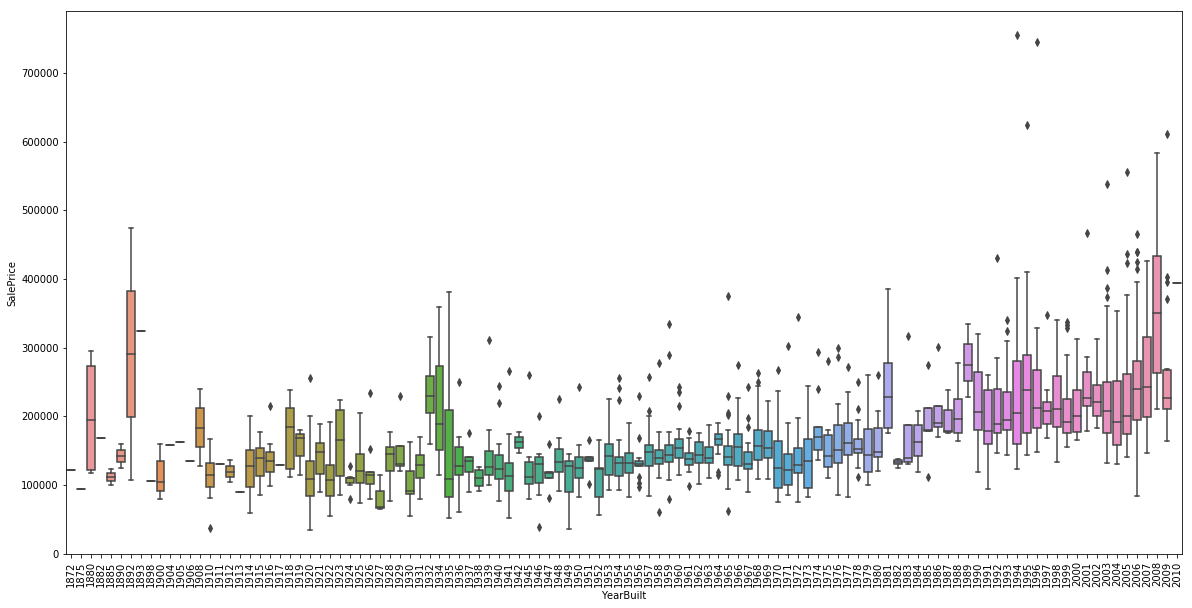

In [129]:
#築年数と物件価格の散布図を作成
#plt.scatter(train["YearBuilt"],train["SalePrice"],color = "#e41a1c")
#plt.xlabel("YearBuilt")
#plt.ylabel("SalePrice")

data = pd.concat([train["YearBuilt"],train["SalePrice"]],axis=1)

plt.figure(figsize=(20, 10))
plt.xticks(rotation='90')
sns.boxplot(x="YearBuilt",y="SalePrice",data=data)

うーん、微妙ですが築年数が新しいほど物件価格が高くなる傾向はありそうです。<br>こちらも外れ値があるので除外します。

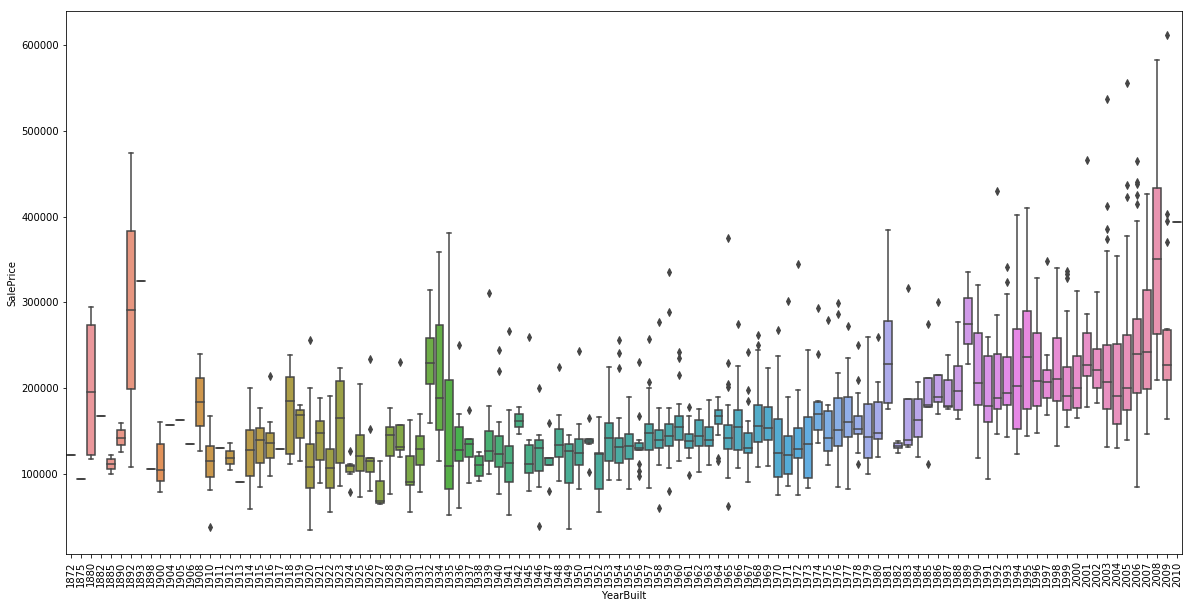

In [130]:
#外れ値を除外する
train = train.drop(train[(train['YearBuilt']<2000) & (train['SalePrice']>600000)].index)

#グラフを描画する
data = pd.concat([train["YearBuilt"],train["SalePrice"]],axis=1)

plt.figure(figsize=(20, 10))
plt.xticks(rotation='90')
sns.boxplot(x="YearBuilt",y="SalePrice",data=data)

### 家の材質と完成度

Text(0, 0.5, 'SalePrice')

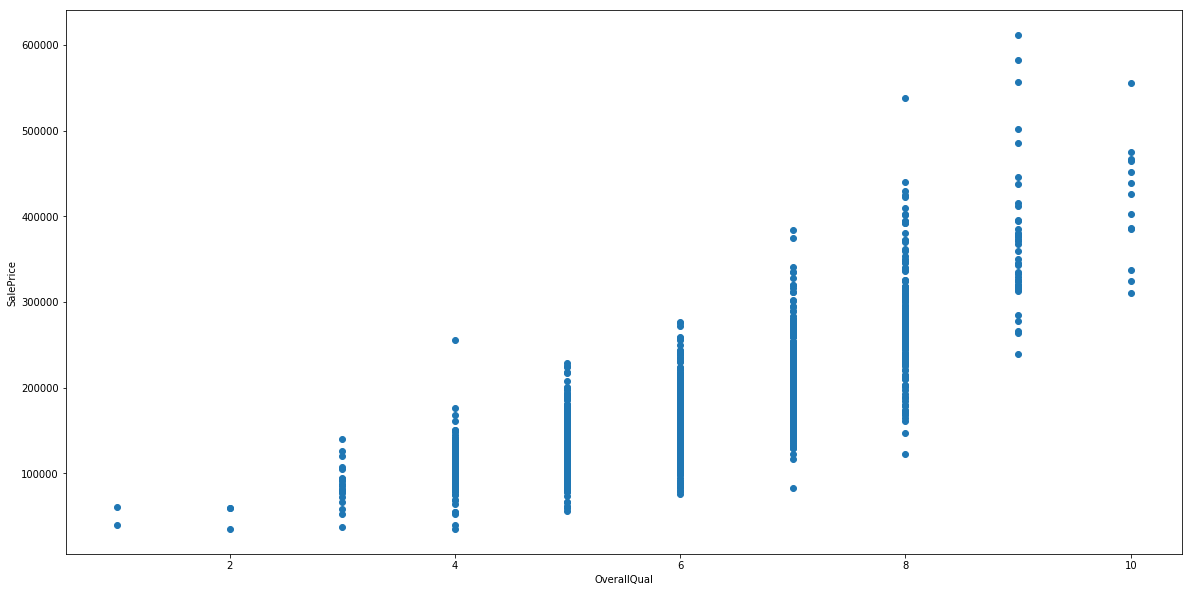

In [131]:
#家の材質・完成度と物件価格の散布図を作成
plt.figure(figsize=(20, 10))
plt.scatter(train["OverallQual"],train["SalePrice"])
plt.xlabel("OverallQual")
plt.ylabel("SalePrice")

Text(0, 0.5, 'SalePrice')

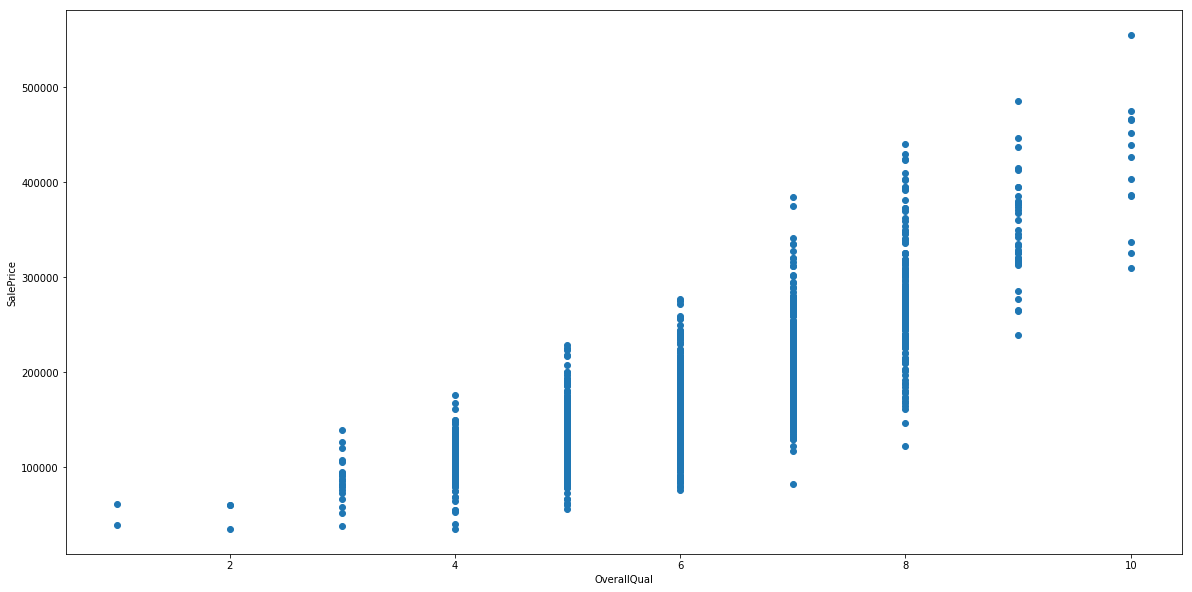

In [132]:
#外れ値を除外する
train = train.drop(train[(train['OverallQual']<5) & (train['SalePrice']>200000)].index)
train = train.drop(train[(train['OverallQual']<10) & (train['SalePrice']>500000)].index)

#グラフを描画する
plt.figure(figsize=(20, 10))
plt.scatter(train["OverallQual"],train["SalePrice"])
plt.xlabel("OverallQual")
plt.ylabel("SalePrice")

## 特徴量エンジニアリング


### 学習データとテストデータをマージする

前処理をいっぺんに行うために、学習データとテストデータをマージします。
さらに学習データに関しては目的変数である「SalesPrice」が含まれているのでこちらは切り出しておきます。

In [133]:
#学習データを目的変数とそれ以外に分ける
train_x = train.drop("SalePrice",axis=1)
train_y = train["SalePrice"]

#学習データとテストデータを統合
all_data = pd.concat([train_x,test_x],axis=0,sort=True)

#IDのカラムは不必要なので別の変数に格納
train_ID = train['Id']
test_ID = test_x['Id']

all_data.drop("Id", axis = 1, inplace = True)

#それぞれのデータのサイズを確認
print("train_x: "+str(train_x.shape))
print("train_y: "+str(train_y.shape))
print("test_x: "+str(test_x.shape))
print("all_data: "+str(all_data.shape))

train_x: (1449, 81)
train_y: (1449,)
test_x: (1459, 81)
all_data: (2908, 80)


### 欠損値の処理

続いて欠損値を処理していきたいと思います。まずはどのくらい欠損値があるのかを確認します。

In [134]:
#データの欠損値を確認する
all_data_na = all_data.isnull().sum()[all_data.isnull().sum()>0].sort_values(ascending=False)
all_data_na

PoolQC          2900
MiscFeature     2803
Alley           2710
Fence           2338
FireplaceQu     1420
LotFrontage      485
GarageCond       159
GarageFinish     159
GarageQual       159
GarageYrBlt      159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Exterior1st        1
Electrical         1
BsmtUnfSF          1
Exterior2nd        1
TotalSF            1
GarageCars         1
KitchenQual        1
BsmtFinSF2         1
BsmtFinSF1         1
SaleType           1
TotalBsmtSF        1
GarageArea         1
dtype: int64

めちゃくちゃありますね、、、グラフ化してみます。

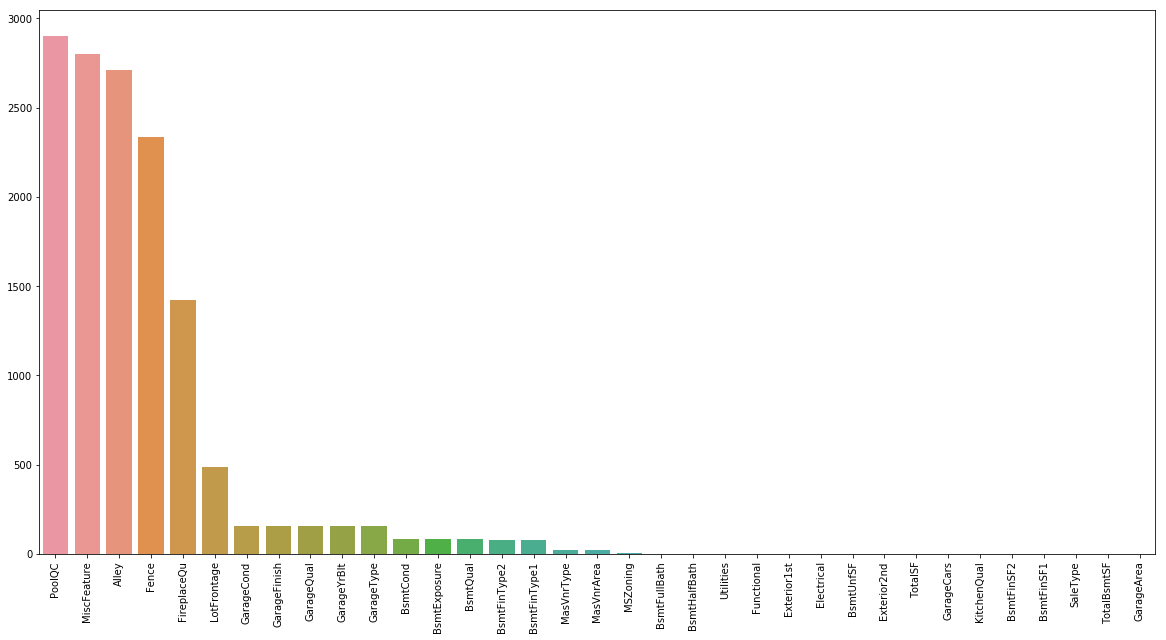

In [135]:
#欠損値の数をグラフ化
plt.figure(figsize=(20,10))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)

欠損値については一括で削除するか、平均値で置換してしまいたくなってしまいますが、<br>
きちんと欠損値が多い変数が何を表すものか見てみます。

* PoolQC: Pool quality<br>
備え付けられているプールの質を表す。プールがない場合にはNAとなる。<br><br>
* MiscFeature: Miscellaneous feature not covered in other categories<br>
その他の備え付けられている設備を表す。エレベータやテニスコートなど。特にない場合はNAとなる。<br><br>
* Alley: Type of alley access to property<br>
物件にアクセスするための道の種類（砂利なのか舗装されているのか）を表す。該当しない場合はNAとなる<br><br>
* Fence: Fence quality<br>
フェンスの質を表す。フェンスがない場合はNAとなる。<br><br>
* FireplaceQu: Fireplace quality<br>
暖炉の品質を表す。暖炉がない場合はNAとなる。<br><br>
* LotFrontage: Linear feet of street connected to property<br>
物件に隣接した道路の長さ。

欠損値が多い変数に関しては、データが欠損しているというわけではなく、欠損＝そもそもその設備がないことを表しているようですね。<br>次に欠損値がある変数のデータ型を確認します。

In [136]:
# 欠損値があるカラムをリスト化
na_col_list = all_data.isnull().sum()[all_data.isnull().sum()>0].index.tolist()

#欠損があるカラムのデータ型を確認
all_data[na_col_list].dtypes.sort_values()

GarageArea      float64
TotalBsmtSF     float64
TotalSF         float64
BsmtFinSF1      float64
BsmtFinSF2      float64
GarageYrBlt     float64
BsmtFullBath    float64
BsmtHalfBath    float64
GarageCars      float64
BsmtUnfSF       float64
MasVnrArea      float64
LotFrontage     float64
GarageType       object
KitchenQual      object
MasVnrType       object
MiscFeature      object
PoolQC           object
SaleType         object
MSZoning         object
GarageQual       object
Alley            object
GarageCond       object
Functional       object
FireplaceQu      object
Fence            object
Exterior2nd      object
Exterior1st      object
Electrical       object
BsmtQual         object
BsmtFinType2     object
BsmtFinType1     object
BsmtExposure     object
BsmtCond         object
GarageFinish     object
Utilities        object
dtype: object

floatとobjectですね。float型の場合は0、objectの場合は"None"で置換することにしましょう。<br>
ただし、隣接した道路の長さ（LotFrontage）に関しては同じ地区と他の物件と同じと思われるので、同じ地区の中央値をとることにします。

In [137]:
#隣接した道路の長さ（LotFrontage）の欠損値の補完
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

#欠損値が存在するかつfloat型のリストを作成
float_list = all_data[na_col_list].dtypes[all_data[na_col_list].dtypes == "float64"].index.tolist()

#欠損値が存在するかつobject型のリストを作成
obj_list = all_data[na_col_list].dtypes[all_data[na_col_list].dtypes == "object"].index.tolist()

#float型の場合は欠損値を0で置換
all_data[float_list] = all_data[float_list].fillna(0)

#object型の場合は欠損値を"None"で置換
all_data[obj_list] = all_data[obj_list].fillna("None")

In [138]:
#欠損値が全て置換できているか確認
all_data.isnull().sum()[all_data.isnull().sum() > 0]

Series([], dtype: int64)

欠損値を処理できました！

### 数値変数の処理

さきほどはカテゴリ変数を処理しましたが、続いては数値変数です。<br>
数値変数は基本はそのままモデルの入力に使えますが、データ上は数値であっても値の大きさや順番に意味のないものはカテゴリ変数として扱うべきです。<br>
もう一度データの定義を見てみると、以下の変数は数値変数ではなくカテゴリ変数として扱ったほうが良さそうです。

* MSSubClass: Identifies the type of dwelling involved in the sale<br>
住宅の種類を表す。数値はどの種類に当てはまるかを表すだけで大きさや順序に意味はない。
* YrSold: Year Sold (YYYY)<br>
販売年<br>
* MoSold: Month Sold (MM)<br>
販売月

In [139]:
# カテゴリ変数に変換する
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

### 目的変数を対数変換

探索的データ分析のフェーズで目的変数であるSalesPriceが正規分布になっていないことがわかりました。<br>
こちらを正規分布に変換します。

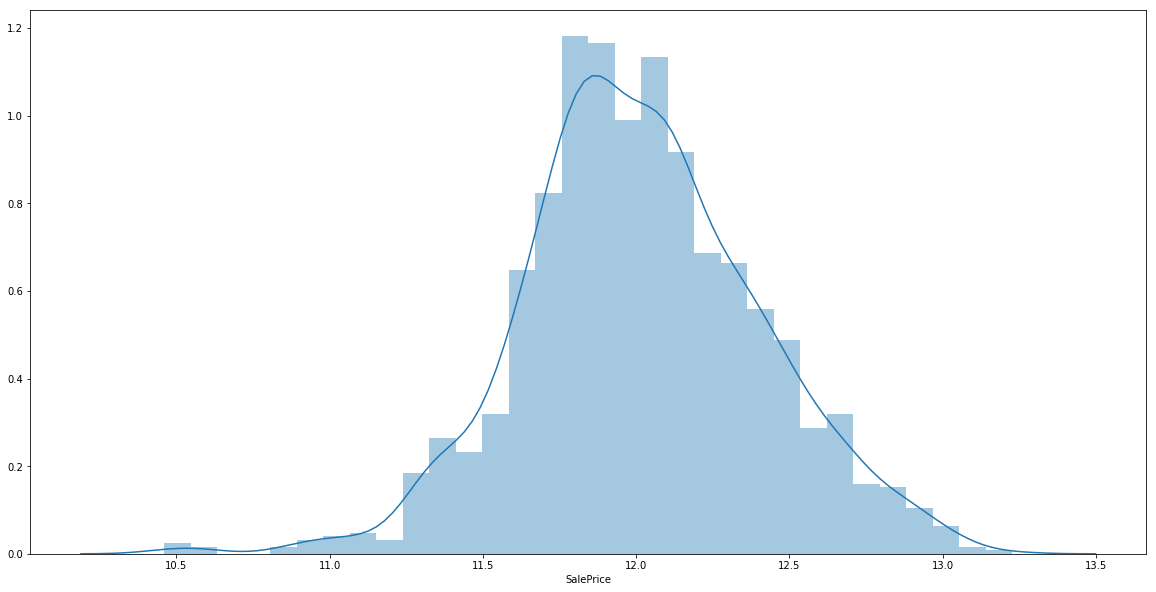

In [140]:
#目的変数の対数log(x+1)をとる
train_y = np.log1p(train_y)

#分布を可視化
plt.figure(figsize=(20, 10))
sns.distplot(train_y)

### 説明変数を対数変換

同様に説明変数に関しても正規分布にしたがっていないものは対数変換していきます。<br>
各説明変数に対して歪度を計算し、0.5よりも大きい場合は対数変換することにします。<br>

歪度について
https://bellcurve.jp/statistics/course/17950.html

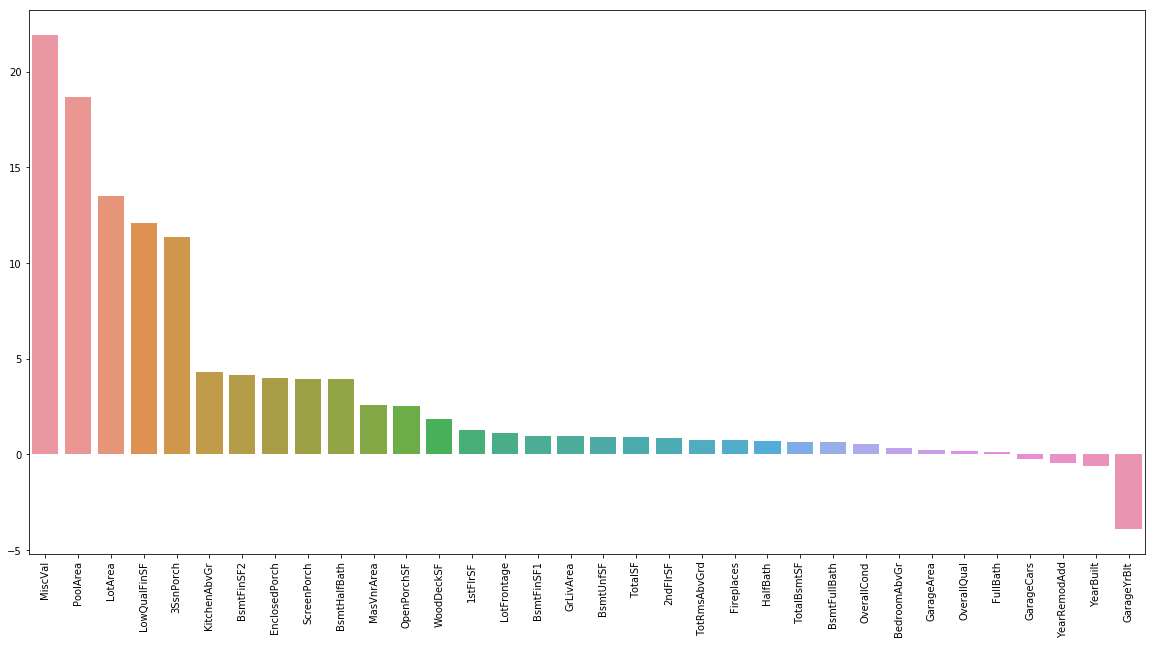

In [141]:
#数値の説明変数のリストを作成
num_feats = all_data.dtypes[all_data.dtypes != "object" ].index

#各説明変数の歪度を計算
skewed_feats = all_data[num_feats].apply(lambda x: x.skew()).sort_values(ascending = False)

#グラフ化
plt.figure(figsize=(20,10))
plt.xticks(rotation='90')
sns.barplot(x=skewed_feats.index, y=skewed_feats)

歪度の閾値は0.5として、それよりも歪度が大きいものは対数変換することにします。

説明変数の場合は対数変換を一般化したBox-Cox変換を使用してみます。<br>
Box-Cox変換については以下の記事がわかりやすいです。<br>
https://qiita.com/dyamaguc/items/b468ae66f9ce6ee89724

ちなみにBox-Cox変換は0以下の値をとる変数には使用できないため、各変数の最小値を見てみます。

In [142]:
#歪度の絶対値が0.5より大きい変数だけに絞る
skewed_feats_over = skewed_feats[abs(skewed_feats) > 0.5].index

In [143]:
#各変数の最小値を表示
for i in skewed_feats_over:
    print(min(all_data[i]))

0
0
1300
0
0
0
0.0
0
0
0.0
0.0
0
0
334
21.0
0.0
334
0.0
0.0
0
2
0
0
0.0
0.0
1
1872
0.0


おっと、、負の値はないですが、0が含まれる変数がありますね、、、<br>
今回はBox-Cox変換ではなく、０以下の値を持つ変数にも適用可能なYeo-Johnson変換を使いたいと思います。

In [144]:
#Yeo-Johnson変換
pt = PowerTransformer()
pt.fit(all_data[skewed_feats_over])

/Users/shin/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:2778: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


PowerTransformer(copy=True, method='yeo-johnson', standardize=True)

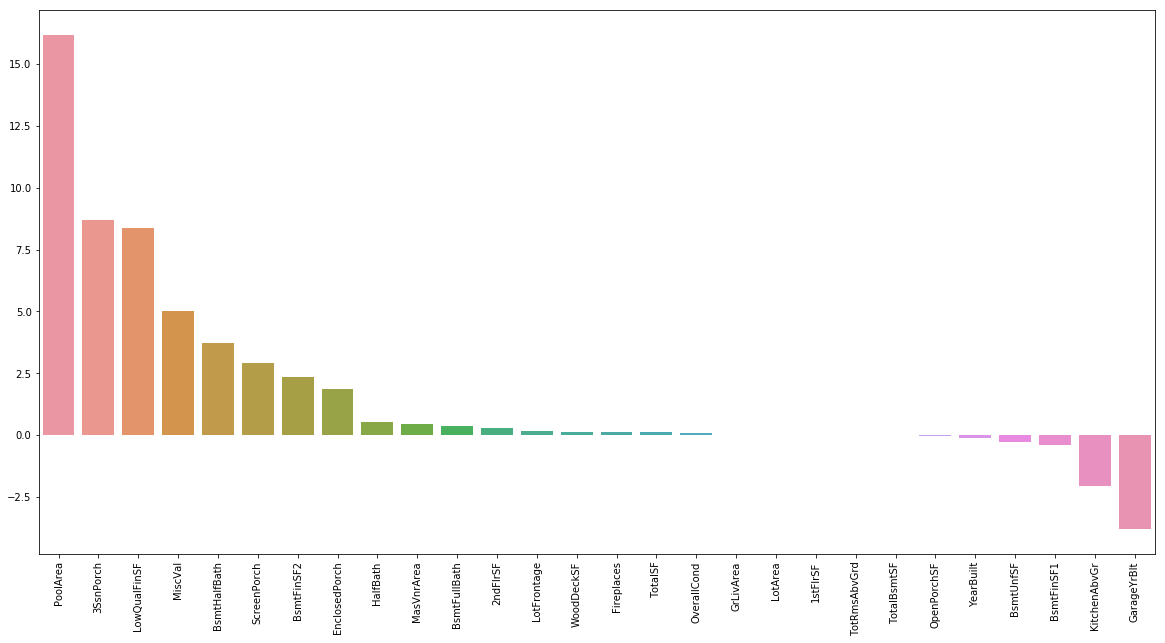

In [145]:
#変換後のデータで各列を置換
all_data[skewed_feats_over] = pt.transform(all_data[skewed_feats_over])

#各説明変数の歪度を計算
skewed_feats_fixed = all_data[skewed_feats_over].apply(lambda x: x.skew()).sort_values(ascending = False)

#グラフ化
plt.figure(figsize=(20,10))
plt.xticks(rotation='90')
sns.barplot(x=skewed_feats_fixed.index, y=skewed_feats_fixed)

In [146]:
skewed_feats_fixed

PoolArea         16.175207
3SsnPorch         8.699744
LowQualFinSF      8.353797
MiscVal           5.029495
BsmtHalfBath      3.713558
ScreenPorch       2.924610
BsmtFinSF2        2.349869
EnclosedPorch     1.877972
HalfBath          0.541561
MasVnrArea        0.463579
BsmtFullBath      0.360710
2ndFlrSF          0.299935
LotFrontage       0.164918
WoodDeckSF        0.140261
Fireplaces        0.115527
TotalSF           0.107442
OverallCond       0.090730
GrLivArea         0.000152
LotArea           0.000000
1stFlrSF          0.000000
TotRmsAbvGrd     -0.000393
TotalBsmtSF      -0.014699
OpenPorchSF      -0.022497
YearBuilt        -0.136011
BsmtUnfSF        -0.278629
BsmtFinSF1       -0.403940
KitchenAbvGr     -2.058865
GarageYrBlt      -3.810394
dtype: float64

### 新たな特徴量の追加

同じくSalesPriceを予測する「Zillow Prize: Zillow’s Home Value Prediction」で、物件の面積を部屋数で割った１部屋当たりの面積という特徴量を追加したことで精度が上がった、ということがあったそうなので今回も追加してみます。<br>

Zillow Prize: Zillow’s Home Value Prediction <br>
https://www.kaggle.com/c/zillow-prize-1

In [147]:
#特徴量に1部屋あたりの面積を追加
all_data["FeetPerRoom"] =  all_data["TotalSF"]/all_data["TotRmsAbvGrd"]

#建築した年とリフォームした年の合計
all_data['YearBuiltAndRemod']=all_data['YearBuilt']+all_data['YearRemodAdd']

#バスルームの合計面積
all_data['Total_Bathrooms'] = (all_data['FullBath'] + (0.5 * all_data['HalfBath']) +
                               all_data['BsmtFullBath'] + (0.5 * all_data['BsmtHalfBath']))

#縁側の合計面積
all_data['Total_porch_sf'] = (all_data['OpenPorchSF'] + all_data['3SsnPorch'] +
                              all_data['EnclosedPorch'] + all_data['ScreenPorch'] +
                              all_data['WoodDeckSF'])

#プールの有無
all_data['haspool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)

#2階の有無
all_data['has2ndfloor'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)

#ガレージの有無
all_data['hasgarage'] = all_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)

#地下室の有無
all_data['hasbsmt'] = all_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)

#暖炉の有無
all_data['hasfireplace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

### カテゴリ変数の処理

カテゴリ変数は多くのモデルでそのまま分析に用いることができません。<br>
そのため、カテゴリ変数をエンコーディングしていきます。

In [148]:
#各カラムのデータ型を確認
all_data.dtypes.value_counts()

object     46
float64    34
int64       9
dtype: int64

カテゴリ変数は44つあります。

In [149]:
#カテゴリ変数となっているカラムを取り出す
cal_list = all_data.dtypes[all_data.dtypes=="object"].index.tolist()

学習データには存在せず、テストデータのみに存在するカテゴリ変数が存在するとモデルがそのカテゴリを学習できず、予測値がおかしくなる可能性があります。<br>テストデータのみに存在するカテゴリ変数が存在しないかを確認しましょう。

In [150]:
#学習データにおけるカテゴリ変数のデータ数を確認
train_x[cal_list].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1449 entries, 0 to 1459
Data columns (total 46 columns):
Alley            91 non-null object
BldgType         1449 non-null object
BsmtCond         1412 non-null object
BsmtExposure     1411 non-null object
BsmtFinType1     1412 non-null object
BsmtFinType2     1411 non-null object
BsmtQual         1412 non-null object
CentralAir       1449 non-null object
Condition1       1449 non-null object
Condition2       1449 non-null object
Electrical       1448 non-null object
ExterCond        1449 non-null object
ExterQual        1449 non-null object
Exterior1st      1449 non-null object
Exterior2nd      1449 non-null object
Fence            280 non-null object
FireplaceQu      759 non-null object
Foundation       1449 non-null object
Functional       1449 non-null object
GarageCond       1368 non-null object
GarageFinish     1368 non-null object
GarageQual       1368 non-null object
GarageType       1368 non-null object
Heating          1449 n

学習データの中に数が0となっているカテゴリ変数はないようですのでそのまま進めていきます。

### one-hot-encodingを行う

カテゴリ変数のエンコーディング方法はさまざまありますのが、今回はone-hot-encodingによってハンドリングします。<br>
one-hot-encodingでは、各カテゴリ変数を（0,1）の二値変数をそれぞれ作成します。これらの二値変数は「ダミー変数」と呼ばれます。<br>
one-hot-encodingについては以下の図がイメージしやすいですです。

https://miro.medium.com/max/2736/0*T5jaa2othYfXZX9W

pandasのget_dummies関数でone-hot-encodingを行います。

In [151]:
#カテゴリ変数をget_dummiesによるone-hot-encodingを行う
all_data = pd.get_dummies(all_data,columns=cal_list)

#サイズを確認
all_data.shape

(2908, 349)

one-hot-encodingをしたことで列数が増えています。列数が増えてしまうことがone-hot-encodingのデメリットなので、それが問題になる場合は他のハンドリング方法を検討する必要がありますが、ここではそのまま進めていきます。

### データの分割

前処理とエンコーディングが終わったのでデータを学習データとテストデータに分割しておきます。

In [152]:
#学習データとテストデータに再分割
train_x = all_data.iloc[:train_x.shape[0],:].reset_index(drop=True)
test_x = all_data.iloc[train_x.shape[0]:,:].reset_index(drop=True)

In [153]:
#サイズを確認
print("train_x: "+str(train_x.shape))
print("test_x: "+str(test_x.shape))

train_x: (1449, 349)
test_x: (1459, 349)


## モデリング

必要なライブラリをインポートします。

In [154]:
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

### クロスバリデーション

モデルの評価用に学習データを学習に使用するデータと評価用データ（バリデーションデータ）に分割します。

In [155]:
# データの分割
train_x, valid_x, train_y, valid_y = train_test_split(
        train_x,
        train_y,
        test_size=0.3,
        random_state=0)

### 予測モデル

#### GBDT（勾配ブースティング木）

まずはGBDT（勾配ブースティング木）を試します。GBDTはランダムフォレストと勾配ブースティング（Gradient Boosting）を組み合わせたアンサンブルです。GBDTには以下の特徴があります。
* 特徴量は数値である必要がある
* 欠損値の補完が不要


In [160]:
#特徴量と目的変数をxgboostのデータ構造に変換する
dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(valid_x,label=valid_y)

/Users/shin/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [169]:
#パラメータを指定してGBDT
num_round = 5000
evallist = [(dvalid, 'eval'), (dtrain, 'train')]

evals_result = {}

#パラメータ
param = {
            'max_depth': 3,
            'eta': 0.01,
            'objective': 'reg:squarederror',
}

#学習の実行
bst = xgb.train(
                        param, dtrain,
                        num_round,
                        evallist,
                        evals_result=evals_result,
                        # 一定ラウンド回しても改善が見込めない場合は学習を打ち切る
                        early_stopping_rounds=1000
                        )
#bst = xgb.train(param, dtrain, num_round)

#[4999]	eval-rmse:0.124586	train-rmse:0.075149
#[4999]	eval-rmse:0.118845	train-rmse:0.073414

[0]	eval-rmse:11.4552	train-rmse:11.3882
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 1000 rounds.
[1]	eval-rmse:11.3416	train-rmse:11.2745
[2]	eval-rmse:11.2291	train-rmse:11.162
[3]	eval-rmse:11.1177	train-rmse:11.0507
[4]	eval-rmse:11.0075	train-rmse:10.9404
[5]	eval-rmse:10.8983	train-rmse:10.8313
[6]	eval-rmse:10.7902	train-rmse:10.7232
[7]	eval-rmse:10.6832	train-rmse:10.6162
[8]	eval-rmse:10.5773	train-rmse:10.5103
[9]	eval-rmse:10.4725	train-rmse:10.4054
[10]	eval-rmse:10.3686	train-rmse:10.3016
[11]	eval-rmse:10.2659	train-rmse:10.1989
[12]	eval-rmse:10.1641	train-rmse:10.0971
[13]	eval-rmse:10.0634	train-rmse:9.99641
[14]	eval-rmse:9.96368	train-rmse:9.8967
[15]	eval-rmse:9.86496	train-rmse:9.79798
[16]	eval-rmse:9.76723	train-rmse:9.70026
[17]	eval-rmse:9.67048	train-rmse:9.60351
[18]	eval-rmse:9.57469	train-rmse:9.50773
[19]	eval-rmse:9.47987	train-rmse:9.41291
[20]	eval-rmse:9.38598	tr

[191]	eval-rmse:1.73307	train-rmse:1.69105
[192]	eval-rmse:1.71621	train-rmse:1.67438
[193]	eval-rmse:1.69966	train-rmse:1.65788
[194]	eval-rmse:1.68314	train-rmse:1.64154
[195]	eval-rmse:1.66678	train-rmse:1.62536
[196]	eval-rmse:1.65072	train-rmse:1.60935
[197]	eval-rmse:1.63468	train-rmse:1.5935
[198]	eval-rmse:1.6188	train-rmse:1.5778
[199]	eval-rmse:1.60315	train-rmse:1.56227
[200]	eval-rmse:1.58772	train-rmse:1.54689
[201]	eval-rmse:1.57226	train-rmse:1.53166
[202]	eval-rmse:1.55702	train-rmse:1.51658
[203]	eval-rmse:1.54193	train-rmse:1.50165
[204]	eval-rmse:1.52692	train-rmse:1.48687
[205]	eval-rmse:1.51224	train-rmse:1.47225
[206]	eval-rmse:1.4976	train-rmse:1.45777
[207]	eval-rmse:1.48304	train-rmse:1.44343
[208]	eval-rmse:1.46877	train-rmse:1.42924
[209]	eval-rmse:1.45456	train-rmse:1.41519
[210]	eval-rmse:1.44053	train-rmse:1.40128
[211]	eval-rmse:1.42654	train-rmse:1.3875
[212]	eval-rmse:1.41267	train-rmse:1.37386
[213]	eval-rmse:1.39906	train-rmse:1.36037
[214]	eval-rmse:

[377]	eval-rmse:0.319495	train-rmse:0.289188
[378]	eval-rmse:0.317072	train-rmse:0.286752
[379]	eval-rmse:0.314675	train-rmse:0.284345
[380]	eval-rmse:0.31232	train-rmse:0.281963
[381]	eval-rmse:0.309934	train-rmse:0.279599
[382]	eval-rmse:0.307625	train-rmse:0.277271
[383]	eval-rmse:0.305318	train-rmse:0.274958
[384]	eval-rmse:0.303041	train-rmse:0.272681
[385]	eval-rmse:0.300824	train-rmse:0.270431
[386]	eval-rmse:0.298571	train-rmse:0.268195
[387]	eval-rmse:0.296394	train-rmse:0.265995
[388]	eval-rmse:0.294204	train-rmse:0.263806
[389]	eval-rmse:0.292063	train-rmse:0.261655
[390]	eval-rmse:0.289923	train-rmse:0.259526
[391]	eval-rmse:0.287811	train-rmse:0.257409
[392]	eval-rmse:0.285743	train-rmse:0.25533
[393]	eval-rmse:0.283678	train-rmse:0.253261
[394]	eval-rmse:0.281658	train-rmse:0.251226
[395]	eval-rmse:0.279686	train-rmse:0.249214
[396]	eval-rmse:0.277713	train-rmse:0.247228
[397]	eval-rmse:0.275749	train-rmse:0.245262
[398]	eval-rmse:0.273827	train-rmse:0.243319
[399]	eval-r

[560]	eval-rmse:0.139605	train-rmse:0.108129
[561]	eval-rmse:0.139365	train-rmse:0.107882
[562]	eval-rmse:0.139109	train-rmse:0.107652
[563]	eval-rmse:0.138889	train-rmse:0.107428
[564]	eval-rmse:0.138685	train-rmse:0.107202
[565]	eval-rmse:0.138488	train-rmse:0.10698
[566]	eval-rmse:0.13828	train-rmse:0.106764
[567]	eval-rmse:0.138037	train-rmse:0.10654
[568]	eval-rmse:0.13783	train-rmse:0.106338
[569]	eval-rmse:0.137627	train-rmse:0.10611
[570]	eval-rmse:0.137413	train-rmse:0.105889
[571]	eval-rmse:0.137242	train-rmse:0.105684
[572]	eval-rmse:0.137063	train-rmse:0.105468
[573]	eval-rmse:0.136835	train-rmse:0.105253
[574]	eval-rmse:0.136658	train-rmse:0.105054
[575]	eval-rmse:0.136457	train-rmse:0.104856
[576]	eval-rmse:0.136276	train-rmse:0.104668
[577]	eval-rmse:0.136061	train-rmse:0.104471
[578]	eval-rmse:0.135904	train-rmse:0.104282
[579]	eval-rmse:0.135716	train-rmse:0.104091
[580]	eval-rmse:0.135544	train-rmse:0.103914
[581]	eval-rmse:0.135375	train-rmse:0.103736
[582]	eval-rmse

[744]	eval-rmse:0.122474	train-rmse:0.088227
[745]	eval-rmse:0.122447	train-rmse:0.088177
[746]	eval-rmse:0.122408	train-rmse:0.088136
[747]	eval-rmse:0.122366	train-rmse:0.088087
[748]	eval-rmse:0.122326	train-rmse:0.088041
[749]	eval-rmse:0.122297	train-rmse:0.087995
[750]	eval-rmse:0.122285	train-rmse:0.087939
[751]	eval-rmse:0.12226	train-rmse:0.087886
[752]	eval-rmse:0.122232	train-rmse:0.087847
[753]	eval-rmse:0.122203	train-rmse:0.087806
[754]	eval-rmse:0.122168	train-rmse:0.087757
[755]	eval-rmse:0.122148	train-rmse:0.087701
[756]	eval-rmse:0.122114	train-rmse:0.087662
[757]	eval-rmse:0.122074	train-rmse:0.087603
[758]	eval-rmse:0.122046	train-rmse:0.087559
[759]	eval-rmse:0.122007	train-rmse:0.087513
[760]	eval-rmse:0.121979	train-rmse:0.087473
[761]	eval-rmse:0.121956	train-rmse:0.087423
[762]	eval-rmse:0.121948	train-rmse:0.087369
[763]	eval-rmse:0.121941	train-rmse:0.087303
[764]	eval-rmse:0.121903	train-rmse:0.087259
[765]	eval-rmse:0.121876	train-rmse:0.08722
[766]	eval-r

[927]	eval-rmse:0.11931	train-rmse:0.081453
[928]	eval-rmse:0.119308	train-rmse:0.081429
[929]	eval-rmse:0.119298	train-rmse:0.081404
[930]	eval-rmse:0.119291	train-rmse:0.081387
[931]	eval-rmse:0.119285	train-rmse:0.081344
[932]	eval-rmse:0.119265	train-rmse:0.081321
[933]	eval-rmse:0.119267	train-rmse:0.081284
[934]	eval-rmse:0.119256	train-rmse:0.081258
[935]	eval-rmse:0.119248	train-rmse:0.081219
[936]	eval-rmse:0.119226	train-rmse:0.081188
[937]	eval-rmse:0.119221	train-rmse:0.081159
[938]	eval-rmse:0.119203	train-rmse:0.081138
[939]	eval-rmse:0.119199	train-rmse:0.081112
[940]	eval-rmse:0.119191	train-rmse:0.081088
[941]	eval-rmse:0.11917	train-rmse:0.081063
[942]	eval-rmse:0.119166	train-rmse:0.081021
[943]	eval-rmse:0.119157	train-rmse:0.080999
[944]	eval-rmse:0.119138	train-rmse:0.080976
[945]	eval-rmse:0.119134	train-rmse:0.080936
[946]	eval-rmse:0.119136	train-rmse:0.08091
[947]	eval-rmse:0.119131	train-rmse:0.080883
[948]	eval-rmse:0.119119	train-rmse:0.080862
[949]	eval-rm

[1108]	eval-rmse:0.117958	train-rmse:0.076645
[1109]	eval-rmse:0.117959	train-rmse:0.076624
[1110]	eval-rmse:0.117952	train-rmse:0.076592
[1111]	eval-rmse:0.117949	train-rmse:0.076571
[1112]	eval-rmse:0.11795	train-rmse:0.076552
[1113]	eval-rmse:0.117933	train-rmse:0.076535
[1114]	eval-rmse:0.117932	train-rmse:0.076498
[1115]	eval-rmse:0.117926	train-rmse:0.076466
[1116]	eval-rmse:0.117922	train-rmse:0.076442
[1117]	eval-rmse:0.117924	train-rmse:0.076422
[1118]	eval-rmse:0.117915	train-rmse:0.076406
[1119]	eval-rmse:0.117907	train-rmse:0.076373
[1120]	eval-rmse:0.117909	train-rmse:0.076356
[1121]	eval-rmse:0.117898	train-rmse:0.076329
[1122]	eval-rmse:0.117893	train-rmse:0.076308
[1123]	eval-rmse:0.117891	train-rmse:0.076288
[1124]	eval-rmse:0.117883	train-rmse:0.076273
[1125]	eval-rmse:0.117891	train-rmse:0.076251
[1126]	eval-rmse:0.117883	train-rmse:0.076233
[1127]	eval-rmse:0.117882	train-rmse:0.076215
[1128]	eval-rmse:0.11788	train-rmse:0.076199
[1129]	eval-rmse:0.11788	train-rmse:

[1287]	eval-rmse:0.117163	train-rmse:0.073061
[1288]	eval-rmse:0.117161	train-rmse:0.073035
[1289]	eval-rmse:0.117163	train-rmse:0.073019
[1290]	eval-rmse:0.117158	train-rmse:0.073011
[1291]	eval-rmse:0.117157	train-rmse:0.072997
[1292]	eval-rmse:0.11715	train-rmse:0.072984
[1293]	eval-rmse:0.117142	train-rmse:0.07297
[1294]	eval-rmse:0.117137	train-rmse:0.072959
[1295]	eval-rmse:0.117137	train-rmse:0.072939
[1296]	eval-rmse:0.117133	train-rmse:0.072921
[1297]	eval-rmse:0.117121	train-rmse:0.072902
[1298]	eval-rmse:0.117109	train-rmse:0.072884
[1299]	eval-rmse:0.117106	train-rmse:0.072872
[1300]	eval-rmse:0.11711	train-rmse:0.072855
[1301]	eval-rmse:0.117109	train-rmse:0.072839
[1302]	eval-rmse:0.117113	train-rmse:0.072819
[1303]	eval-rmse:0.11711	train-rmse:0.072806
[1304]	eval-rmse:0.117101	train-rmse:0.072785
[1305]	eval-rmse:0.117086	train-rmse:0.072748
[1306]	eval-rmse:0.117092	train-rmse:0.072723
[1307]	eval-rmse:0.117086	train-rmse:0.072702
[1308]	eval-rmse:0.117084	train-rmse:0

[1467]	eval-rmse:0.116584	train-rmse:0.070104
[1468]	eval-rmse:0.116588	train-rmse:0.070091
[1469]	eval-rmse:0.116592	train-rmse:0.070077
[1470]	eval-rmse:0.116586	train-rmse:0.070052
[1471]	eval-rmse:0.116587	train-rmse:0.070035
[1472]	eval-rmse:0.116583	train-rmse:0.070029
[1473]	eval-rmse:0.116587	train-rmse:0.070013
[1474]	eval-rmse:0.116588	train-rmse:0.069985
[1475]	eval-rmse:0.116585	train-rmse:0.069979
[1476]	eval-rmse:0.116573	train-rmse:0.06997
[1477]	eval-rmse:0.116577	train-rmse:0.069957
[1478]	eval-rmse:0.116573	train-rmse:0.069945
[1479]	eval-rmse:0.116564	train-rmse:0.069931
[1480]	eval-rmse:0.116563	train-rmse:0.069916
[1481]	eval-rmse:0.116554	train-rmse:0.069894
[1482]	eval-rmse:0.116548	train-rmse:0.069879
[1483]	eval-rmse:0.116546	train-rmse:0.069862
[1484]	eval-rmse:0.116553	train-rmse:0.06984
[1485]	eval-rmse:0.116542	train-rmse:0.069828
[1486]	eval-rmse:0.11654	train-rmse:0.069817
[1487]	eval-rmse:0.116532	train-rmse:0.069806
[1488]	eval-rmse:0.116541	train-rmse:

[1647]	eval-rmse:0.116161	train-rmse:0.067229
[1648]	eval-rmse:0.11616	train-rmse:0.067213
[1649]	eval-rmse:0.116154	train-rmse:0.067203
[1650]	eval-rmse:0.116164	train-rmse:0.067162
[1651]	eval-rmse:0.116155	train-rmse:0.067149
[1652]	eval-rmse:0.116147	train-rmse:0.067136
[1653]	eval-rmse:0.116144	train-rmse:0.067118
[1654]	eval-rmse:0.116138	train-rmse:0.067098
[1655]	eval-rmse:0.116133	train-rmse:0.067088
[1656]	eval-rmse:0.116126	train-rmse:0.067075
[1657]	eval-rmse:0.116124	train-rmse:0.067054
[1658]	eval-rmse:0.116118	train-rmse:0.067047
[1659]	eval-rmse:0.116122	train-rmse:0.067036
[1660]	eval-rmse:0.116125	train-rmse:0.067022
[1661]	eval-rmse:0.116119	train-rmse:0.067002
[1662]	eval-rmse:0.116125	train-rmse:0.066983
[1663]	eval-rmse:0.116133	train-rmse:0.066971
[1664]	eval-rmse:0.116125	train-rmse:0.066954
[1665]	eval-rmse:0.11613	train-rmse:0.066933
[1666]	eval-rmse:0.116128	train-rmse:0.066922
[1667]	eval-rmse:0.116119	train-rmse:0.066908
[1668]	eval-rmse:0.116113	train-rmse

[1826]	eval-rmse:0.115787	train-rmse:0.064414
[1827]	eval-rmse:0.115784	train-rmse:0.064404
[1828]	eval-rmse:0.115772	train-rmse:0.064389
[1829]	eval-rmse:0.115768	train-rmse:0.064374
[1830]	eval-rmse:0.115773	train-rmse:0.064363
[1831]	eval-rmse:0.115769	train-rmse:0.064357
[1832]	eval-rmse:0.115773	train-rmse:0.064347
[1833]	eval-rmse:0.115773	train-rmse:0.064339
[1834]	eval-rmse:0.115765	train-rmse:0.06432
[1835]	eval-rmse:0.115764	train-rmse:0.064303
[1836]	eval-rmse:0.115756	train-rmse:0.064291
[1837]	eval-rmse:0.115755	train-rmse:0.064282
[1838]	eval-rmse:0.11575	train-rmse:0.06426
[1839]	eval-rmse:0.115746	train-rmse:0.064255
[1840]	eval-rmse:0.115743	train-rmse:0.06424
[1841]	eval-rmse:0.115731	train-rmse:0.064226
[1842]	eval-rmse:0.115731	train-rmse:0.064212
[1843]	eval-rmse:0.115732	train-rmse:0.064195
[1844]	eval-rmse:0.115719	train-rmse:0.064181
[1845]	eval-rmse:0.115727	train-rmse:0.064143
[1846]	eval-rmse:0.115725	train-rmse:0.064124
[1847]	eval-rmse:0.115723	train-rmse:0

[2005]	eval-rmse:0.115406	train-rmse:0.061875
[2006]	eval-rmse:0.115414	train-rmse:0.061841
[2007]	eval-rmse:0.115409	train-rmse:0.061836
[2008]	eval-rmse:0.115402	train-rmse:0.061819
[2009]	eval-rmse:0.115392	train-rmse:0.061807
[2010]	eval-rmse:0.11539	train-rmse:0.061794
[2011]	eval-rmse:0.115388	train-rmse:0.061786
[2012]	eval-rmse:0.115386	train-rmse:0.061768
[2013]	eval-rmse:0.11539	train-rmse:0.061759
[2014]	eval-rmse:0.115392	train-rmse:0.061737
[2015]	eval-rmse:0.115387	train-rmse:0.061728
[2016]	eval-rmse:0.115382	train-rmse:0.061714
[2017]	eval-rmse:0.115384	train-rmse:0.061698
[2018]	eval-rmse:0.115383	train-rmse:0.061689
[2019]	eval-rmse:0.115386	train-rmse:0.061681
[2020]	eval-rmse:0.115388	train-rmse:0.061665
[2021]	eval-rmse:0.115374	train-rmse:0.061653
[2022]	eval-rmse:0.115384	train-rmse:0.061619
[2023]	eval-rmse:0.115376	train-rmse:0.061606
[2024]	eval-rmse:0.115377	train-rmse:0.061599
[2025]	eval-rmse:0.115372	train-rmse:0.061592
[2026]	eval-rmse:0.115367	train-rmse

[2185]	eval-rmse:0.115133	train-rmse:0.059769
[2186]	eval-rmse:0.115129	train-rmse:0.059751
[2187]	eval-rmse:0.115128	train-rmse:0.059742
[2188]	eval-rmse:0.115126	train-rmse:0.059737
[2189]	eval-rmse:0.115122	train-rmse:0.059727
[2190]	eval-rmse:0.115124	train-rmse:0.059719
[2191]	eval-rmse:0.115127	train-rmse:0.059711
[2192]	eval-rmse:0.115124	train-rmse:0.059692
[2193]	eval-rmse:0.115119	train-rmse:0.059684
[2194]	eval-rmse:0.115126	train-rmse:0.059666
[2195]	eval-rmse:0.115126	train-rmse:0.059657
[2196]	eval-rmse:0.115129	train-rmse:0.05965
[2197]	eval-rmse:0.115122	train-rmse:0.059637
[2198]	eval-rmse:0.115126	train-rmse:0.059627
[2199]	eval-rmse:0.115128	train-rmse:0.059617
[2200]	eval-rmse:0.115128	train-rmse:0.059602
[2201]	eval-rmse:0.115124	train-rmse:0.059582
[2202]	eval-rmse:0.115122	train-rmse:0.059573
[2203]	eval-rmse:0.115122	train-rmse:0.059559
[2204]	eval-rmse:0.115112	train-rmse:0.059549
[2205]	eval-rmse:0.115115	train-rmse:0.059528
[2206]	eval-rmse:0.115112	train-rms

[2364]	eval-rmse:0.11491	train-rmse:0.057865
[2365]	eval-rmse:0.114916	train-rmse:0.057851
[2366]	eval-rmse:0.114914	train-rmse:0.057842
[2367]	eval-rmse:0.114914	train-rmse:0.057828
[2368]	eval-rmse:0.114912	train-rmse:0.057822
[2369]	eval-rmse:0.114906	train-rmse:0.057813
[2370]	eval-rmse:0.114902	train-rmse:0.057809
[2371]	eval-rmse:0.114898	train-rmse:0.057803
[2372]	eval-rmse:0.114897	train-rmse:0.05779
[2373]	eval-rmse:0.114897	train-rmse:0.057783
[2374]	eval-rmse:0.1149	train-rmse:0.057777
[2375]	eval-rmse:0.114903	train-rmse:0.05777
[2376]	eval-rmse:0.114901	train-rmse:0.057765
[2377]	eval-rmse:0.114898	train-rmse:0.057757
[2378]	eval-rmse:0.114896	train-rmse:0.057744
[2379]	eval-rmse:0.114894	train-rmse:0.057737
[2380]	eval-rmse:0.114892	train-rmse:0.057733
[2381]	eval-rmse:0.114891	train-rmse:0.057723
[2382]	eval-rmse:0.114891	train-rmse:0.057701
[2383]	eval-rmse:0.114897	train-rmse:0.057693
[2384]	eval-rmse:0.114894	train-rmse:0.057685
[2385]	eval-rmse:0.114893	train-rmse:0.

[2543]	eval-rmse:0.114675	train-rmse:0.056166
[2544]	eval-rmse:0.114677	train-rmse:0.056154
[2545]	eval-rmse:0.114675	train-rmse:0.056147
[2546]	eval-rmse:0.114677	train-rmse:0.056141
[2547]	eval-rmse:0.114672	train-rmse:0.056133
[2548]	eval-rmse:0.114669	train-rmse:0.056106
[2549]	eval-rmse:0.114667	train-rmse:0.056091
[2550]	eval-rmse:0.114664	train-rmse:0.056084
[2551]	eval-rmse:0.11466	train-rmse:0.056073
[2552]	eval-rmse:0.114661	train-rmse:0.056068
[2553]	eval-rmse:0.114656	train-rmse:0.05606
[2554]	eval-rmse:0.114657	train-rmse:0.056047
[2555]	eval-rmse:0.114653	train-rmse:0.056031
[2556]	eval-rmse:0.114655	train-rmse:0.056027
[2557]	eval-rmse:0.114651	train-rmse:0.05602
[2558]	eval-rmse:0.114643	train-rmse:0.056008
[2559]	eval-rmse:0.114644	train-rmse:0.055994
[2560]	eval-rmse:0.114641	train-rmse:0.055967
[2561]	eval-rmse:0.114632	train-rmse:0.055959
[2562]	eval-rmse:0.114627	train-rmse:0.055952
[2563]	eval-rmse:0.114624	train-rmse:0.055946
[2564]	eval-rmse:0.114623	train-rmse:

[2722]	eval-rmse:0.114462	train-rmse:0.054503
[2723]	eval-rmse:0.114462	train-rmse:0.054497
[2724]	eval-rmse:0.114455	train-rmse:0.054489
[2725]	eval-rmse:0.114453	train-rmse:0.05448
[2726]	eval-rmse:0.11445	train-rmse:0.054474
[2727]	eval-rmse:0.114449	train-rmse:0.054461
[2728]	eval-rmse:0.114449	train-rmse:0.054456
[2729]	eval-rmse:0.114451	train-rmse:0.054446
[2730]	eval-rmse:0.11445	train-rmse:0.05444
[2731]	eval-rmse:0.114453	train-rmse:0.054431
[2732]	eval-rmse:0.114446	train-rmse:0.054421
[2733]	eval-rmse:0.114444	train-rmse:0.054413
[2734]	eval-rmse:0.114447	train-rmse:0.054408
[2735]	eval-rmse:0.114444	train-rmse:0.054405
[2736]	eval-rmse:0.114446	train-rmse:0.054394
[2737]	eval-rmse:0.114445	train-rmse:0.054389
[2738]	eval-rmse:0.114442	train-rmse:0.054373
[2739]	eval-rmse:0.114446	train-rmse:0.05436
[2740]	eval-rmse:0.114445	train-rmse:0.054353
[2741]	eval-rmse:0.114444	train-rmse:0.054345
[2742]	eval-rmse:0.114442	train-rmse:0.054338
[2743]	eval-rmse:0.11444	train-rmse:0.0

[2901]	eval-rmse:0.114322	train-rmse:0.053038
[2902]	eval-rmse:0.114321	train-rmse:0.053025
[2903]	eval-rmse:0.114314	train-rmse:0.053016
[2904]	eval-rmse:0.114315	train-rmse:0.053011
[2905]	eval-rmse:0.114319	train-rmse:0.052996
[2906]	eval-rmse:0.114312	train-rmse:0.052987
[2907]	eval-rmse:0.114317	train-rmse:0.052979
[2908]	eval-rmse:0.114311	train-rmse:0.05297
[2909]	eval-rmse:0.114311	train-rmse:0.052953
[2910]	eval-rmse:0.114311	train-rmse:0.052948
[2911]	eval-rmse:0.114316	train-rmse:0.052942
[2912]	eval-rmse:0.114316	train-rmse:0.052935
[2913]	eval-rmse:0.114311	train-rmse:0.052916
[2914]	eval-rmse:0.114305	train-rmse:0.052907
[2915]	eval-rmse:0.114307	train-rmse:0.052901
[2916]	eval-rmse:0.114306	train-rmse:0.052896
[2917]	eval-rmse:0.114301	train-rmse:0.05289
[2918]	eval-rmse:0.114298	train-rmse:0.052881
[2919]	eval-rmse:0.114296	train-rmse:0.052875
[2920]	eval-rmse:0.114298	train-rmse:0.052871
[2921]	eval-rmse:0.114293	train-rmse:0.052865
[2922]	eval-rmse:0.114298	train-rmse

[3080]	eval-rmse:0.114159	train-rmse:0.051618
[3081]	eval-rmse:0.114157	train-rmse:0.051613
[3082]	eval-rmse:0.114159	train-rmse:0.051607
[3083]	eval-rmse:0.114154	train-rmse:0.05159
[3084]	eval-rmse:0.114154	train-rmse:0.051571
[3085]	eval-rmse:0.114152	train-rmse:0.051562
[3086]	eval-rmse:0.114148	train-rmse:0.051548
[3087]	eval-rmse:0.114151	train-rmse:0.051543
[3088]	eval-rmse:0.114155	train-rmse:0.051538
[3089]	eval-rmse:0.114158	train-rmse:0.051532
[3090]	eval-rmse:0.114157	train-rmse:0.051525
[3091]	eval-rmse:0.114155	train-rmse:0.051522
[3092]	eval-rmse:0.114152	train-rmse:0.051511
[3093]	eval-rmse:0.114152	train-rmse:0.0515
[3094]	eval-rmse:0.11415	train-rmse:0.051495
[3095]	eval-rmse:0.114141	train-rmse:0.051482
[3096]	eval-rmse:0.114145	train-rmse:0.051474
[3097]	eval-rmse:0.114143	train-rmse:0.051471
[3098]	eval-rmse:0.114142	train-rmse:0.051466
[3099]	eval-rmse:0.114138	train-rmse:0.05146
[3100]	eval-rmse:0.114134	train-rmse:0.051452
[3101]	eval-rmse:0.11413	train-rmse:0.0

[3259]	eval-rmse:0.114002	train-rmse:0.050251
[3260]	eval-rmse:0.113999	train-rmse:0.050246
[3261]	eval-rmse:0.113994	train-rmse:0.050232
[3262]	eval-rmse:0.113992	train-rmse:0.05023
[3263]	eval-rmse:0.113999	train-rmse:0.05022
[3264]	eval-rmse:0.113996	train-rmse:0.050216
[3265]	eval-rmse:0.113997	train-rmse:0.050212
[3266]	eval-rmse:0.113992	train-rmse:0.050204
[3267]	eval-rmse:0.113993	train-rmse:0.050193
[3268]	eval-rmse:0.113998	train-rmse:0.050186
[3269]	eval-rmse:0.113996	train-rmse:0.050178
[3270]	eval-rmse:0.113994	train-rmse:0.050175
[3271]	eval-rmse:0.113994	train-rmse:0.050165
[3272]	eval-rmse:0.113993	train-rmse:0.050156
[3273]	eval-rmse:0.113989	train-rmse:0.050151
[3274]	eval-rmse:0.11399	train-rmse:0.050144
[3275]	eval-rmse:0.113987	train-rmse:0.050139
[3276]	eval-rmse:0.113988	train-rmse:0.050126
[3277]	eval-rmse:0.113985	train-rmse:0.050121
[3278]	eval-rmse:0.113985	train-rmse:0.050116
[3279]	eval-rmse:0.113987	train-rmse:0.050112
[3280]	eval-rmse:0.113988	train-rmse:

[3438]	eval-rmse:0.113904	train-rmse:0.049007
[3439]	eval-rmse:0.113903	train-rmse:0.048997
[3440]	eval-rmse:0.113901	train-rmse:0.048995
[3441]	eval-rmse:0.113898	train-rmse:0.048991
[3442]	eval-rmse:0.1139	train-rmse:0.048982
[3443]	eval-rmse:0.113901	train-rmse:0.048979
[3444]	eval-rmse:0.113903	train-rmse:0.048967
[3445]	eval-rmse:0.113899	train-rmse:0.048962
[3446]	eval-rmse:0.113902	train-rmse:0.048944
[3447]	eval-rmse:0.113907	train-rmse:0.048938
[3448]	eval-rmse:0.113913	train-rmse:0.048921
[3449]	eval-rmse:0.11391	train-rmse:0.048915
[3450]	eval-rmse:0.113909	train-rmse:0.048913
[3451]	eval-rmse:0.113907	train-rmse:0.048903
[3452]	eval-rmse:0.113906	train-rmse:0.048895
[3453]	eval-rmse:0.113904	train-rmse:0.048891
[3454]	eval-rmse:0.113901	train-rmse:0.048886
[3455]	eval-rmse:0.113899	train-rmse:0.048879
[3456]	eval-rmse:0.113897	train-rmse:0.04887
[3457]	eval-rmse:0.113893	train-rmse:0.048862
[3458]	eval-rmse:0.113894	train-rmse:0.04886
[3459]	eval-rmse:0.113894	train-rmse:0.

[3618]	eval-rmse:0.113751	train-rmse:0.04774
[3619]	eval-rmse:0.113751	train-rmse:0.047736
[3620]	eval-rmse:0.113757	train-rmse:0.047726
[3621]	eval-rmse:0.113753	train-rmse:0.047721
[3622]	eval-rmse:0.113754	train-rmse:0.047711
[3623]	eval-rmse:0.11375	train-rmse:0.047705
[3624]	eval-rmse:0.113748	train-rmse:0.047703
[3625]	eval-rmse:0.113751	train-rmse:0.047694
[3626]	eval-rmse:0.11375	train-rmse:0.047687
[3627]	eval-rmse:0.113748	train-rmse:0.047683
[3628]	eval-rmse:0.113749	train-rmse:0.04768
[3629]	eval-rmse:0.113749	train-rmse:0.047673
[3630]	eval-rmse:0.113745	train-rmse:0.047666
[3631]	eval-rmse:0.113746	train-rmse:0.047664
[3632]	eval-rmse:0.113745	train-rmse:0.047661
[3633]	eval-rmse:0.113743	train-rmse:0.047656
[3634]	eval-rmse:0.113742	train-rmse:0.047647
[3635]	eval-rmse:0.113742	train-rmse:0.04764
[3636]	eval-rmse:0.113743	train-rmse:0.047635
[3637]	eval-rmse:0.113742	train-rmse:0.047631
[3638]	eval-rmse:0.113741	train-rmse:0.047617
[3639]	eval-rmse:0.113746	train-rmse:0.

[3798]	eval-rmse:0.113699	train-rmse:0.046637
[3799]	eval-rmse:0.113698	train-rmse:0.046631
[3800]	eval-rmse:0.113698	train-rmse:0.046621
[3801]	eval-rmse:0.113697	train-rmse:0.046619
[3802]	eval-rmse:0.113697	train-rmse:0.046615
[3803]	eval-rmse:0.113696	train-rmse:0.046612
[3804]	eval-rmse:0.113691	train-rmse:0.046605
[3805]	eval-rmse:0.113687	train-rmse:0.046603
[3806]	eval-rmse:0.113683	train-rmse:0.046599
[3807]	eval-rmse:0.113688	train-rmse:0.046595
[3808]	eval-rmse:0.113689	train-rmse:0.046589
[3809]	eval-rmse:0.113689	train-rmse:0.046586
[3810]	eval-rmse:0.113691	train-rmse:0.046582
[3811]	eval-rmse:0.113693	train-rmse:0.04658
[3812]	eval-rmse:0.113691	train-rmse:0.046575
[3813]	eval-rmse:0.11369	train-rmse:0.046571
[3814]	eval-rmse:0.113691	train-rmse:0.046563
[3815]	eval-rmse:0.113692	train-rmse:0.046551
[3816]	eval-rmse:0.113691	train-rmse:0.046538
[3817]	eval-rmse:0.113692	train-rmse:0.046535
[3818]	eval-rmse:0.11369	train-rmse:0.046532
[3819]	eval-rmse:0.11369	train-rmse:0

[3977]	eval-rmse:0.113609	train-rmse:0.045654
[3978]	eval-rmse:0.113605	train-rmse:0.045648
[3979]	eval-rmse:0.113608	train-rmse:0.04564
[3980]	eval-rmse:0.113606	train-rmse:0.045628
[3981]	eval-rmse:0.11361	train-rmse:0.045619
[3982]	eval-rmse:0.113607	train-rmse:0.045607
[3983]	eval-rmse:0.113609	train-rmse:0.045601
[3984]	eval-rmse:0.11361	train-rmse:0.045599
[3985]	eval-rmse:0.113607	train-rmse:0.045594
[3986]	eval-rmse:0.113608	train-rmse:0.045588
[3987]	eval-rmse:0.113612	train-rmse:0.045583
[3988]	eval-rmse:0.113611	train-rmse:0.045579
[3989]	eval-rmse:0.113611	train-rmse:0.045577
[3990]	eval-rmse:0.113609	train-rmse:0.045572
[3991]	eval-rmse:0.11361	train-rmse:0.045568
[3992]	eval-rmse:0.113607	train-rmse:0.045565
[3993]	eval-rmse:0.113605	train-rmse:0.045554
[3994]	eval-rmse:0.113606	train-rmse:0.045541
[3995]	eval-rmse:0.113605	train-rmse:0.045538
[3996]	eval-rmse:0.113603	train-rmse:0.045532
[3997]	eval-rmse:0.113608	train-rmse:0.045527
[3998]	eval-rmse:0.113604	train-rmse:0

[4157]	eval-rmse:0.113535	train-rmse:0.044668
[4158]	eval-rmse:0.113533	train-rmse:0.044663
[4159]	eval-rmse:0.113527	train-rmse:0.044657
[4160]	eval-rmse:0.113527	train-rmse:0.044655
[4161]	eval-rmse:0.113531	train-rmse:0.044648
[4162]	eval-rmse:0.113534	train-rmse:0.044635
[4163]	eval-rmse:0.113532	train-rmse:0.044631
[4164]	eval-rmse:0.11353	train-rmse:0.044619
[4165]	eval-rmse:0.113531	train-rmse:0.04461
[4166]	eval-rmse:0.113535	train-rmse:0.044605
[4167]	eval-rmse:0.113534	train-rmse:0.044601
[4168]	eval-rmse:0.113535	train-rmse:0.0446
[4169]	eval-rmse:0.113534	train-rmse:0.04459
[4170]	eval-rmse:0.113533	train-rmse:0.044586
[4171]	eval-rmse:0.113531	train-rmse:0.044584
[4172]	eval-rmse:0.11353	train-rmse:0.044579
[4173]	eval-rmse:0.113531	train-rmse:0.044566
[4174]	eval-rmse:0.11353	train-rmse:0.044564
[4175]	eval-rmse:0.113528	train-rmse:0.044558
[4176]	eval-rmse:0.113527	train-rmse:0.044557
[4177]	eval-rmse:0.113525	train-rmse:0.044551
[4178]	eval-rmse:0.113525	train-rmse:0.04

[4336]	eval-rmse:0.113489	train-rmse:0.043605
[4337]	eval-rmse:0.113485	train-rmse:0.0436
[4338]	eval-rmse:0.113487	train-rmse:0.043584
[4339]	eval-rmse:0.113489	train-rmse:0.043573
[4340]	eval-rmse:0.113488	train-rmse:0.043571
[4341]	eval-rmse:0.11349	train-rmse:0.043565
[4342]	eval-rmse:0.11349	train-rmse:0.043563
[4343]	eval-rmse:0.113495	train-rmse:0.043554
[4344]	eval-rmse:0.11349	train-rmse:0.043549
[4345]	eval-rmse:0.113491	train-rmse:0.04354
[4346]	eval-rmse:0.113491	train-rmse:0.043536
[4347]	eval-rmse:0.113489	train-rmse:0.04353
[4348]	eval-rmse:0.113489	train-rmse:0.043528
[4349]	eval-rmse:0.113489	train-rmse:0.043522
[4350]	eval-rmse:0.113488	train-rmse:0.043521
[4351]	eval-rmse:0.113487	train-rmse:0.043519
[4352]	eval-rmse:0.113485	train-rmse:0.043507
[4353]	eval-rmse:0.113489	train-rmse:0.043499
[4354]	eval-rmse:0.113492	train-rmse:0.043494
[4355]	eval-rmse:0.113488	train-rmse:0.043488
[4356]	eval-rmse:0.113487	train-rmse:0.043484
[4357]	eval-rmse:0.113488	train-rmse:0.04

[4516]	eval-rmse:0.113504	train-rmse:0.042399
[4517]	eval-rmse:0.113503	train-rmse:0.042393
[4518]	eval-rmse:0.113502	train-rmse:0.042385
[4519]	eval-rmse:0.113503	train-rmse:0.042383
[4520]	eval-rmse:0.113503	train-rmse:0.042379
[4521]	eval-rmse:0.113501	train-rmse:0.042371
[4522]	eval-rmse:0.1135	train-rmse:0.042369
[4523]	eval-rmse:0.113498	train-rmse:0.042365
[4524]	eval-rmse:0.113502	train-rmse:0.042358
[4525]	eval-rmse:0.113503	train-rmse:0.042343
[4526]	eval-rmse:0.113505	train-rmse:0.042328
[4527]	eval-rmse:0.113503	train-rmse:0.042323
[4528]	eval-rmse:0.113503	train-rmse:0.042312
[4529]	eval-rmse:0.113501	train-rmse:0.042303
[4530]	eval-rmse:0.113502	train-rmse:0.042293
[4531]	eval-rmse:0.1135	train-rmse:0.042289
[4532]	eval-rmse:0.113506	train-rmse:0.042277
[4533]	eval-rmse:0.113504	train-rmse:0.042273
[4534]	eval-rmse:0.113503	train-rmse:0.042271
[4535]	eval-rmse:0.113501	train-rmse:0.042266
[4536]	eval-rmse:0.113503	train-rmse:0.042265
[4537]	eval-rmse:0.113499	train-rmse:0

[4696]	eval-rmse:0.113547	train-rmse:0.041248
[4697]	eval-rmse:0.113546	train-rmse:0.041242
[4698]	eval-rmse:0.113545	train-rmse:0.041234
[4699]	eval-rmse:0.113543	train-rmse:0.041229
[4700]	eval-rmse:0.113544	train-rmse:0.041223
[4701]	eval-rmse:0.113542	train-rmse:0.041219
[4702]	eval-rmse:0.113544	train-rmse:0.041217
[4703]	eval-rmse:0.113542	train-rmse:0.041216
[4704]	eval-rmse:0.113542	train-rmse:0.041209
[4705]	eval-rmse:0.113544	train-rmse:0.041205
[4706]	eval-rmse:0.11354	train-rmse:0.041198
[4707]	eval-rmse:0.113542	train-rmse:0.041192
[4708]	eval-rmse:0.113542	train-rmse:0.041188
[4709]	eval-rmse:0.113541	train-rmse:0.041186
[4710]	eval-rmse:0.113535	train-rmse:0.041181
[4711]	eval-rmse:0.113539	train-rmse:0.04117
[4712]	eval-rmse:0.113542	train-rmse:0.041166
[4713]	eval-rmse:0.113541	train-rmse:0.041162
[4714]	eval-rmse:0.113542	train-rmse:0.041157
[4715]	eval-rmse:0.113544	train-rmse:0.041151
[4716]	eval-rmse:0.113543	train-rmse:0.041145
[4717]	eval-rmse:0.113542	train-rmse

[4875]	eval-rmse:0.113545	train-rmse:0.040069
[4876]	eval-rmse:0.113543	train-rmse:0.040062
[4877]	eval-rmse:0.113542	train-rmse:0.040057
[4878]	eval-rmse:0.113541	train-rmse:0.040052
[4879]	eval-rmse:0.113542	train-rmse:0.040045
[4880]	eval-rmse:0.11354	train-rmse:0.040041
[4881]	eval-rmse:0.113546	train-rmse:0.040031
[4882]	eval-rmse:0.113544	train-rmse:0.040027
[4883]	eval-rmse:0.113539	train-rmse:0.040022
[4884]	eval-rmse:0.11354	train-rmse:0.040009
[4885]	eval-rmse:0.113538	train-rmse:0.040008
[4886]	eval-rmse:0.113545	train-rmse:0.039991
[4887]	eval-rmse:0.113545	train-rmse:0.039985
[4888]	eval-rmse:0.113547	train-rmse:0.03998
[4889]	eval-rmse:0.113548	train-rmse:0.039974
[4890]	eval-rmse:0.113548	train-rmse:0.03997
[4891]	eval-rmse:0.113546	train-rmse:0.039964
[4892]	eval-rmse:0.113548	train-rmse:0.039952
[4893]	eval-rmse:0.113552	train-rmse:0.039938
[4894]	eval-rmse:0.113552	train-rmse:0.039934
[4895]	eval-rmse:0.113551	train-rmse:0.03993
[4896]	eval-rmse:0.113552	train-rmse:0.

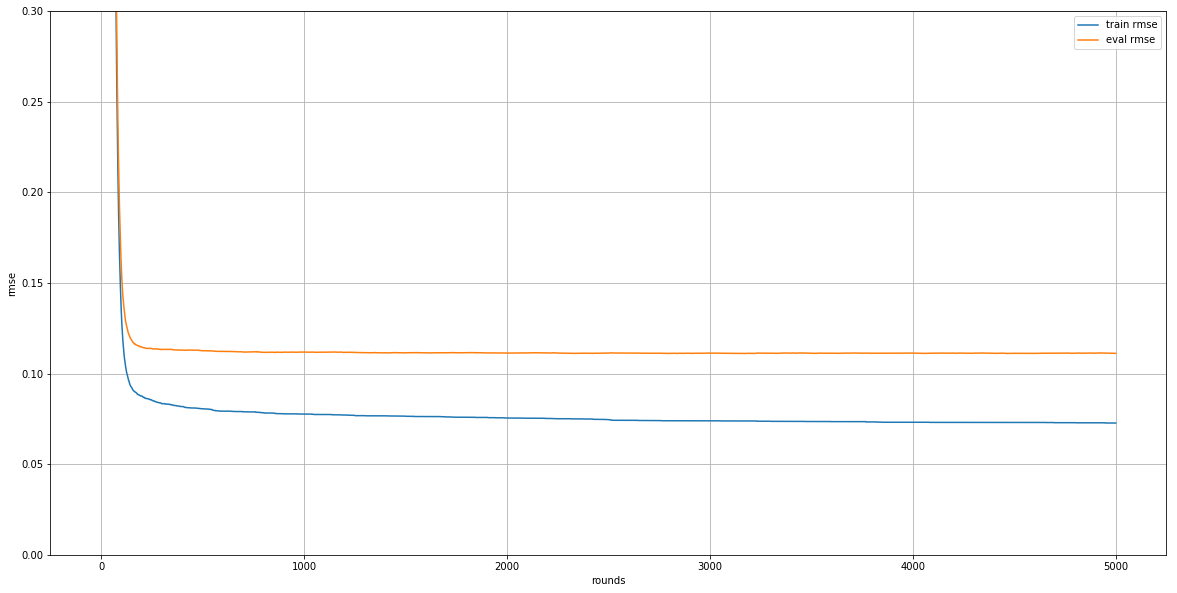

In [162]:
#学習曲線を可視化する
plt.figure(figsize=(20, 10))
train_metric = evals_result['train']['rmse']
plt.plot(train_metric, label='train rmse')
eval_metric = evals_result['eval']['rmse']
plt.plot(eval_metric, label='eval rmse')
plt.grid()
plt.legend()
plt.xlabel('rounds')
plt.ylabel('rmse')
plt.ylim(0, 0.3)
plt.show()

In [1]:
xgb.to_graphviz(bst, num_trees=200)

NameError: name 'xgb' is not defined

In [42]:
bst.predict(dtrain)

array([12.213451 , 11.4511595, 11.934907 , ..., 11.621128 , 11.908296 ,
       12.31496  ], dtype=float32)

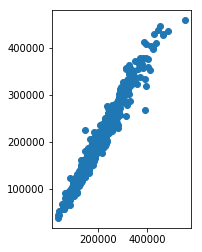

In [163]:
plt.subplots_adjust(wspace=0.4)
plt.subplot(121)
plt.scatter(np.exp(train_y),np.exp(bst.predict(dtrain)))

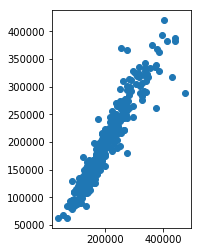

In [164]:
plt.subplots_adjust(wspace=0.4)
plt.subplot(121)
plt.scatter(np.exp(valid_y),np.exp(bst.predict(dvalid)))

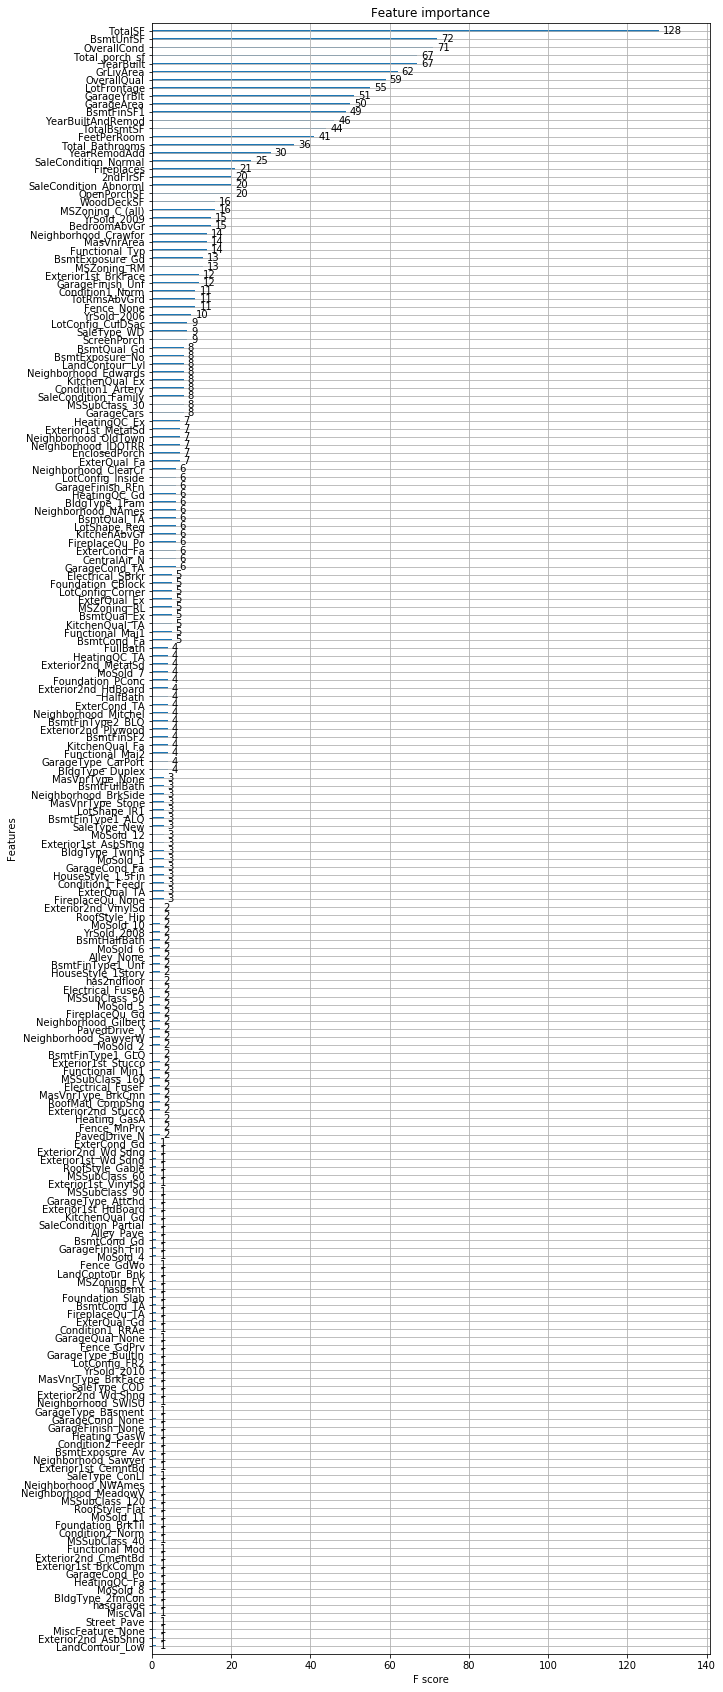

In [165]:
#特徴量ごとの重要度を可視化する
ax = xgb.plot_importance(bst)
fig = ax.figure
fig.set_size_inches(10, 30)

#### lightgbm

In [156]:
# データセットを生成する
lgb_train = lgb.Dataset(train_x, train_y)
lgb_eval = lgb.Dataset(valid_x, valid_y, reference=lgb_train)

In [167]:
#LightGBM のハイパーパラメータ
lgb_params = {
        'objective': 'regression',
        'num_leaves': 10,
        'learning_rate': 0.01, 
        'n_estimators': 5000,
        'max_bin': 200, 
        'bagging_fraction': 0.75,
        'bagging_freq': 5, 
        'bagging_seed': 7,
        'feature_fraction': 0.2,
        'feature_fraction_seed': 7,
        'verbose': -1,
        'metric': 'rmse'
    }

lgb_evals_result = {}

# 上記のパラメータでモデルを学習する
lightgbm = lgb.train(
                    lgb_params, 
                    lgb_train, 
                    valid_sets=lgb_eval,
                    evals_result=lgb_evals_result,
                )

ypred = lightgbm.predict(train_x)

/Users/shin/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 0.382406
[2]	valid_0's rmse: 0.379862
[3]	valid_0's rmse: 0.377507
[4]	valid_0's rmse: 0.374888
[5]	valid_0's rmse: 0.372028
[6]	valid_0's rmse: 0.369282
[7]	valid_0's rmse: 0.366617
[8]	valid_0's rmse: 0.363694
[9]	valid_0's rmse: 0.361333
[10]	valid_0's rmse: 0.358512
[11]	valid_0's rmse: 0.35592
[12]	valid_0's rmse: 0.35314
[13]	valid_0's rmse: 0.350522
[14]	valid_0's rmse: 0.347811
[15]	valid_0's rmse: 0.34543
[16]	valid_0's rmse: 0.343088
[17]	valid_0's rmse: 0.341046
[18]	valid_0's rmse: 0.338735
[19]	valid_0's rmse: 0.336646
[20]	valid_0's rmse: 0.334943
[21]	valid_0's rmse: 0.333022
[22]	valid_0's rmse: 0.3311
[23]	valid_0's rmse: 0.328996
[24]	valid_0's rmse: 0.327082
[25]	valid_0's rmse: 0.324657
[26]	valid_0's rmse: 0.322379
[27]	valid_0's rmse: 0.320294
[28]	valid_0's rmse: 0.318449
[29]	valid_0's rmse: 0.316461
[30]	valid_0's rmse: 0.314016
[31]	valid_0's rmse: 0.312178
[32]	valid_0's rmse: 0.309985
[33]	valid_0's rmse: 0.308019
[34]	valid_0's rmse: 0.3

[309]	valid_0's rmse: 0.128842
[310]	valid_0's rmse: 0.128707
[311]	valid_0's rmse: 0.128586
[312]	valid_0's rmse: 0.128499
[313]	valid_0's rmse: 0.128435
[314]	valid_0's rmse: 0.128344
[315]	valid_0's rmse: 0.128236
[316]	valid_0's rmse: 0.128052
[317]	valid_0's rmse: 0.127926
[318]	valid_0's rmse: 0.127813
[319]	valid_0's rmse: 0.127692
[320]	valid_0's rmse: 0.1276
[321]	valid_0's rmse: 0.127504
[322]	valid_0's rmse: 0.127423
[323]	valid_0's rmse: 0.127285
[324]	valid_0's rmse: 0.1272
[325]	valid_0's rmse: 0.127133
[326]	valid_0's rmse: 0.127036
[327]	valid_0's rmse: 0.126911
[328]	valid_0's rmse: 0.126784
[329]	valid_0's rmse: 0.126675
[330]	valid_0's rmse: 0.126573
[331]	valid_0's rmse: 0.126457
[332]	valid_0's rmse: 0.126335
[333]	valid_0's rmse: 0.12624
[334]	valid_0's rmse: 0.12611
[335]	valid_0's rmse: 0.126033
[336]	valid_0's rmse: 0.125927
[337]	valid_0's rmse: 0.125826
[338]	valid_0's rmse: 0.125679
[339]	valid_0's rmse: 0.125594
[340]	valid_0's rmse: 0.125497
[341]	valid_0'

[697]	valid_0's rmse: 0.11356
[698]	valid_0's rmse: 0.113559
[699]	valid_0's rmse: 0.113558
[700]	valid_0's rmse: 0.113555
[701]	valid_0's rmse: 0.113548
[702]	valid_0's rmse: 0.11353
[703]	valid_0's rmse: 0.113525
[704]	valid_0's rmse: 0.1135
[705]	valid_0's rmse: 0.113493
[706]	valid_0's rmse: 0.11351
[707]	valid_0's rmse: 0.113496
[708]	valid_0's rmse: 0.113482
[709]	valid_0's rmse: 0.113511
[710]	valid_0's rmse: 0.113515
[711]	valid_0's rmse: 0.113515
[712]	valid_0's rmse: 0.113507
[713]	valid_0's rmse: 0.113502
[714]	valid_0's rmse: 0.113506
[715]	valid_0's rmse: 0.113497
[716]	valid_0's rmse: 0.113485
[717]	valid_0's rmse: 0.113451
[718]	valid_0's rmse: 0.113462
[719]	valid_0's rmse: 0.113447
[720]	valid_0's rmse: 0.113445
[721]	valid_0's rmse: 0.113423
[722]	valid_0's rmse: 0.113387
[723]	valid_0's rmse: 0.113386
[724]	valid_0's rmse: 0.113387
[725]	valid_0's rmse: 0.113393
[726]	valid_0's rmse: 0.113379
[727]	valid_0's rmse: 0.11337
[728]	valid_0's rmse: 0.113362
[729]	valid_0'

[968]	valid_0's rmse: 0.112648
[969]	valid_0's rmse: 0.112646
[970]	valid_0's rmse: 0.11264
[971]	valid_0's rmse: 0.112615
[972]	valid_0's rmse: 0.112608
[973]	valid_0's rmse: 0.112595
[974]	valid_0's rmse: 0.112616
[975]	valid_0's rmse: 0.112654
[976]	valid_0's rmse: 0.112658
[977]	valid_0's rmse: 0.112642
[978]	valid_0's rmse: 0.112638
[979]	valid_0's rmse: 0.112638
[980]	valid_0's rmse: 0.11263
[981]	valid_0's rmse: 0.112621
[982]	valid_0's rmse: 0.112621
[983]	valid_0's rmse: 0.112606
[984]	valid_0's rmse: 0.112612
[985]	valid_0's rmse: 0.112612
[986]	valid_0's rmse: 0.112607
[987]	valid_0's rmse: 0.11259
[988]	valid_0's rmse: 0.112597
[989]	valid_0's rmse: 0.11259
[990]	valid_0's rmse: 0.112591
[991]	valid_0's rmse: 0.112584
[992]	valid_0's rmse: 0.112589
[993]	valid_0's rmse: 0.11258
[994]	valid_0's rmse: 0.112572
[995]	valid_0's rmse: 0.112575
[996]	valid_0's rmse: 0.112584
[997]	valid_0's rmse: 0.112572
[998]	valid_0's rmse: 0.112574
[999]	valid_0's rmse: 0.112556
[1000]	valid_

[1267]	valid_0's rmse: 0.112454
[1268]	valid_0's rmse: 0.112443
[1269]	valid_0's rmse: 0.11244
[1270]	valid_0's rmse: 0.112441
[1271]	valid_0's rmse: 0.112449
[1272]	valid_0's rmse: 0.112463
[1273]	valid_0's rmse: 0.112456
[1274]	valid_0's rmse: 0.112453
[1275]	valid_0's rmse: 0.112456
[1276]	valid_0's rmse: 0.112481
[1277]	valid_0's rmse: 0.112482
[1278]	valid_0's rmse: 0.112493
[1279]	valid_0's rmse: 0.112487
[1280]	valid_0's rmse: 0.1125
[1281]	valid_0's rmse: 0.112488
[1282]	valid_0's rmse: 0.112485
[1283]	valid_0's rmse: 0.112488
[1284]	valid_0's rmse: 0.11249
[1285]	valid_0's rmse: 0.112483
[1286]	valid_0's rmse: 0.112476
[1287]	valid_0's rmse: 0.112466
[1288]	valid_0's rmse: 0.112481
[1289]	valid_0's rmse: 0.112484
[1290]	valid_0's rmse: 0.112482
[1291]	valid_0's rmse: 0.112482
[1292]	valid_0's rmse: 0.112488
[1293]	valid_0's rmse: 0.112498
[1294]	valid_0's rmse: 0.112507
[1295]	valid_0's rmse: 0.112508
[1296]	valid_0's rmse: 0.112522
[1297]	valid_0's rmse: 0.112514
[1298]	valid

[1558]	valid_0's rmse: 0.112545
[1559]	valid_0's rmse: 0.112545
[1560]	valid_0's rmse: 0.112552
[1561]	valid_0's rmse: 0.112553
[1562]	valid_0's rmse: 0.112562
[1563]	valid_0's rmse: 0.112565
[1564]	valid_0's rmse: 0.112576
[1565]	valid_0's rmse: 0.112572
[1566]	valid_0's rmse: 0.112557
[1567]	valid_0's rmse: 0.112543
[1568]	valid_0's rmse: 0.112541
[1569]	valid_0's rmse: 0.112532
[1570]	valid_0's rmse: 0.112533
[1571]	valid_0's rmse: 0.112528
[1572]	valid_0's rmse: 0.112537
[1573]	valid_0's rmse: 0.11254
[1574]	valid_0's rmse: 0.112546
[1575]	valid_0's rmse: 0.112536
[1576]	valid_0's rmse: 0.112541
[1577]	valid_0's rmse: 0.112541
[1578]	valid_0's rmse: 0.112544
[1579]	valid_0's rmse: 0.112554
[1580]	valid_0's rmse: 0.112559
[1581]	valid_0's rmse: 0.112568
[1582]	valid_0's rmse: 0.112583
[1583]	valid_0's rmse: 0.112595
[1584]	valid_0's rmse: 0.112611
[1585]	valid_0's rmse: 0.112611
[1586]	valid_0's rmse: 0.112594
[1587]	valid_0's rmse: 0.112577
[1588]	valid_0's rmse: 0.112575
[1589]	va

[1827]	valid_0's rmse: 0.112675
[1828]	valid_0's rmse: 0.112658
[1829]	valid_0's rmse: 0.112661
[1830]	valid_0's rmse: 0.112659
[1831]	valid_0's rmse: 0.112667
[1832]	valid_0's rmse: 0.112665
[1833]	valid_0's rmse: 0.112666
[1834]	valid_0's rmse: 0.112666
[1835]	valid_0's rmse: 0.112669
[1836]	valid_0's rmse: 0.112666
[1837]	valid_0's rmse: 0.112675
[1838]	valid_0's rmse: 0.112686
[1839]	valid_0's rmse: 0.112708
[1840]	valid_0's rmse: 0.11271
[1841]	valid_0's rmse: 0.112705
[1842]	valid_0's rmse: 0.112708
[1843]	valid_0's rmse: 0.11271
[1844]	valid_0's rmse: 0.112711
[1845]	valid_0's rmse: 0.112722
[1846]	valid_0's rmse: 0.112729
[1847]	valid_0's rmse: 0.112729
[1848]	valid_0's rmse: 0.112742
[1849]	valid_0's rmse: 0.112745
[1850]	valid_0's rmse: 0.112747
[1851]	valid_0's rmse: 0.112742
[1852]	valid_0's rmse: 0.112727
[1853]	valid_0's rmse: 0.112726
[1854]	valid_0's rmse: 0.112719
[1855]	valid_0's rmse: 0.112714
[1856]	valid_0's rmse: 0.112712
[1857]	valid_0's rmse: 0.112701
[1858]	val

[2096]	valid_0's rmse: 0.113035
[2097]	valid_0's rmse: 0.113035
[2098]	valid_0's rmse: 0.113036
[2099]	valid_0's rmse: 0.113035
[2100]	valid_0's rmse: 0.113035
[2101]	valid_0's rmse: 0.11304
[2102]	valid_0's rmse: 0.113034
[2103]	valid_0's rmse: 0.113038
[2104]	valid_0's rmse: 0.113033
[2105]	valid_0's rmse: 0.113039
[2106]	valid_0's rmse: 0.113029
[2107]	valid_0's rmse: 0.11303
[2108]	valid_0's rmse: 0.113035
[2109]	valid_0's rmse: 0.113027
[2110]	valid_0's rmse: 0.11302
[2111]	valid_0's rmse: 0.113015
[2112]	valid_0's rmse: 0.113003
[2113]	valid_0's rmse: 0.113
[2114]	valid_0's rmse: 0.112985
[2115]	valid_0's rmse: 0.11298
[2116]	valid_0's rmse: 0.112982
[2117]	valid_0's rmse: 0.11299
[2118]	valid_0's rmse: 0.11299
[2119]	valid_0's rmse: 0.112998
[2120]	valid_0's rmse: 0.113006
[2121]	valid_0's rmse: 0.113012
[2122]	valid_0's rmse: 0.113022
[2123]	valid_0's rmse: 0.113008
[2124]	valid_0's rmse: 0.113019
[2125]	valid_0's rmse: 0.113022
[2126]	valid_0's rmse: 0.113023
[2127]	valid_0's 

[2371]	valid_0's rmse: 0.113283
[2372]	valid_0's rmse: 0.113281
[2373]	valid_0's rmse: 0.113288
[2374]	valid_0's rmse: 0.113288
[2375]	valid_0's rmse: 0.113287
[2376]	valid_0's rmse: 0.113293
[2377]	valid_0's rmse: 0.113288
[2378]	valid_0's rmse: 0.113264
[2379]	valid_0's rmse: 0.11327
[2380]	valid_0's rmse: 0.113271
[2381]	valid_0's rmse: 0.113273
[2382]	valid_0's rmse: 0.11328
[2383]	valid_0's rmse: 0.113298
[2384]	valid_0's rmse: 0.113296
[2385]	valid_0's rmse: 0.113289
[2386]	valid_0's rmse: 0.113298
[2387]	valid_0's rmse: 0.113305
[2388]	valid_0's rmse: 0.113306
[2389]	valid_0's rmse: 0.113315
[2390]	valid_0's rmse: 0.113316
[2391]	valid_0's rmse: 0.113317
[2392]	valid_0's rmse: 0.113318
[2393]	valid_0's rmse: 0.113326
[2394]	valid_0's rmse: 0.113317
[2395]	valid_0's rmse: 0.113315
[2396]	valid_0's rmse: 0.11331
[2397]	valid_0's rmse: 0.113303
[2398]	valid_0's rmse: 0.113308
[2399]	valid_0's rmse: 0.11331
[2400]	valid_0's rmse: 0.113308
[2401]	valid_0's rmse: 0.113306
[2402]	valid

[2701]	valid_0's rmse: 0.113545
[2702]	valid_0's rmse: 0.113545
[2703]	valid_0's rmse: 0.113551
[2704]	valid_0's rmse: 0.113554
[2705]	valid_0's rmse: 0.11354
[2706]	valid_0's rmse: 0.113547
[2707]	valid_0's rmse: 0.113542
[2708]	valid_0's rmse: 0.11354
[2709]	valid_0's rmse: 0.113538
[2710]	valid_0's rmse: 0.113541
[2711]	valid_0's rmse: 0.11355
[2712]	valid_0's rmse: 0.113547
[2713]	valid_0's rmse: 0.113557
[2714]	valid_0's rmse: 0.113561
[2715]	valid_0's rmse: 0.113563
[2716]	valid_0's rmse: 0.113567
[2717]	valid_0's rmse: 0.113565
[2718]	valid_0's rmse: 0.113556
[2719]	valid_0's rmse: 0.113561
[2720]	valid_0's rmse: 0.11356
[2721]	valid_0's rmse: 0.113565
[2722]	valid_0's rmse: 0.11357
[2723]	valid_0's rmse: 0.113588
[2724]	valid_0's rmse: 0.113587
[2725]	valid_0's rmse: 0.113594
[2726]	valid_0's rmse: 0.113592
[2727]	valid_0's rmse: 0.113584
[2728]	valid_0's rmse: 0.113583
[2729]	valid_0's rmse: 0.113586
[2730]	valid_0's rmse: 0.113578
[2731]	valid_0's rmse: 0.113575
[2732]	valid_

[3032]	valid_0's rmse: 0.113919
[3033]	valid_0's rmse: 0.113929
[3034]	valid_0's rmse: 0.113922
[3035]	valid_0's rmse: 0.113926
[3036]	valid_0's rmse: 0.113913
[3037]	valid_0's rmse: 0.113903
[3038]	valid_0's rmse: 0.113893
[3039]	valid_0's rmse: 0.113889
[3040]	valid_0's rmse: 0.113879
[3041]	valid_0's rmse: 0.11387
[3042]	valid_0's rmse: 0.113878
[3043]	valid_0's rmse: 0.113886
[3044]	valid_0's rmse: 0.113883
[3045]	valid_0's rmse: 0.11389
[3046]	valid_0's rmse: 0.113888
[3047]	valid_0's rmse: 0.113883
[3048]	valid_0's rmse: 0.113881
[3049]	valid_0's rmse: 0.113879
[3050]	valid_0's rmse: 0.11387
[3051]	valid_0's rmse: 0.113873
[3052]	valid_0's rmse: 0.113876
[3053]	valid_0's rmse: 0.113883
[3054]	valid_0's rmse: 0.113895
[3055]	valid_0's rmse: 0.113889
[3056]	valid_0's rmse: 0.113893
[3057]	valid_0's rmse: 0.113899
[3058]	valid_0's rmse: 0.113897
[3059]	valid_0's rmse: 0.113895
[3060]	valid_0's rmse: 0.113904
[3061]	valid_0's rmse: 0.113903
[3062]	valid_0's rmse: 0.113901
[3063]	vali

[3327]	valid_0's rmse: 0.114056
[3328]	valid_0's rmse: 0.114056
[3329]	valid_0's rmse: 0.114053
[3330]	valid_0's rmse: 0.114052
[3331]	valid_0's rmse: 0.11405
[3332]	valid_0's rmse: 0.114042
[3333]	valid_0's rmse: 0.114046
[3334]	valid_0's rmse: 0.114056
[3335]	valid_0's rmse: 0.114058
[3336]	valid_0's rmse: 0.114052
[3337]	valid_0's rmse: 0.114051
[3338]	valid_0's rmse: 0.114051
[3339]	valid_0's rmse: 0.114054
[3340]	valid_0's rmse: 0.114056
[3341]	valid_0's rmse: 0.114057
[3342]	valid_0's rmse: 0.114053
[3343]	valid_0's rmse: 0.114052
[3344]	valid_0's rmse: 0.114055
[3345]	valid_0's rmse: 0.114056
[3346]	valid_0's rmse: 0.114064
[3347]	valid_0's rmse: 0.114064
[3348]	valid_0's rmse: 0.11406
[3349]	valid_0's rmse: 0.114064
[3350]	valid_0's rmse: 0.114075
[3351]	valid_0's rmse: 0.114077
[3352]	valid_0's rmse: 0.114074
[3353]	valid_0's rmse: 0.114079
[3354]	valid_0's rmse: 0.114072
[3355]	valid_0's rmse: 0.114076
[3356]	valid_0's rmse: 0.114078
[3357]	valid_0's rmse: 0.114079
[3358]	val

[3589]	valid_0's rmse: 0.114377
[3590]	valid_0's rmse: 0.114387
[3591]	valid_0's rmse: 0.114382
[3592]	valid_0's rmse: 0.114383
[3593]	valid_0's rmse: 0.114383
[3594]	valid_0's rmse: 0.114385
[3595]	valid_0's rmse: 0.114381
[3596]	valid_0's rmse: 0.114393
[3597]	valid_0's rmse: 0.1144
[3598]	valid_0's rmse: 0.114399
[3599]	valid_0's rmse: 0.114401
[3600]	valid_0's rmse: 0.114402
[3601]	valid_0's rmse: 0.114395
[3602]	valid_0's rmse: 0.114386
[3603]	valid_0's rmse: 0.11439
[3604]	valid_0's rmse: 0.114385
[3605]	valid_0's rmse: 0.114383
[3606]	valid_0's rmse: 0.114376
[3607]	valid_0's rmse: 0.114379
[3608]	valid_0's rmse: 0.11438
[3609]	valid_0's rmse: 0.114381
[3610]	valid_0's rmse: 0.114382
[3611]	valid_0's rmse: 0.114381
[3612]	valid_0's rmse: 0.114377
[3613]	valid_0's rmse: 0.114373
[3614]	valid_0's rmse: 0.114371
[3615]	valid_0's rmse: 0.114377
[3616]	valid_0's rmse: 0.114374
[3617]	valid_0's rmse: 0.11437
[3618]	valid_0's rmse: 0.114369
[3619]	valid_0's rmse: 0.114371
[3620]	valid_

[3929]	valid_0's rmse: 0.114656
[3930]	valid_0's rmse: 0.114656
[3931]	valid_0's rmse: 0.114655
[3932]	valid_0's rmse: 0.114657
[3933]	valid_0's rmse: 0.114662
[3934]	valid_0's rmse: 0.114659
[3935]	valid_0's rmse: 0.114657
[3936]	valid_0's rmse: 0.114656
[3937]	valid_0's rmse: 0.11466
[3938]	valid_0's rmse: 0.114662
[3939]	valid_0's rmse: 0.114661
[3940]	valid_0's rmse: 0.114663
[3941]	valid_0's rmse: 0.114667
[3942]	valid_0's rmse: 0.114664
[3943]	valid_0's rmse: 0.114662
[3944]	valid_0's rmse: 0.114668
[3945]	valid_0's rmse: 0.114668
[3946]	valid_0's rmse: 0.114674
[3947]	valid_0's rmse: 0.114676
[3948]	valid_0's rmse: 0.114679
[3949]	valid_0's rmse: 0.114678
[3950]	valid_0's rmse: 0.11467
[3951]	valid_0's rmse: 0.114668
[3952]	valid_0's rmse: 0.11467
[3953]	valid_0's rmse: 0.114673
[3954]	valid_0's rmse: 0.114673
[3955]	valid_0's rmse: 0.114678
[3956]	valid_0's rmse: 0.114674
[3957]	valid_0's rmse: 0.114671
[3958]	valid_0's rmse: 0.114666
[3959]	valid_0's rmse: 0.114667
[3960]	vali

[4186]	valid_0's rmse: 0.114775
[4187]	valid_0's rmse: 0.11477
[4188]	valid_0's rmse: 0.114768
[4189]	valid_0's rmse: 0.114772
[4190]	valid_0's rmse: 0.114773
[4191]	valid_0's rmse: 0.114775
[4192]	valid_0's rmse: 0.114774
[4193]	valid_0's rmse: 0.11477
[4194]	valid_0's rmse: 0.114769
[4195]	valid_0's rmse: 0.114767
[4196]	valid_0's rmse: 0.114762
[4197]	valid_0's rmse: 0.114752
[4198]	valid_0's rmse: 0.114753
[4199]	valid_0's rmse: 0.114753
[4200]	valid_0's rmse: 0.114756
[4201]	valid_0's rmse: 0.114759
[4202]	valid_0's rmse: 0.114755
[4203]	valid_0's rmse: 0.114759
[4204]	valid_0's rmse: 0.114762
[4205]	valid_0's rmse: 0.114763
[4206]	valid_0's rmse: 0.114765
[4207]	valid_0's rmse: 0.114767
[4208]	valid_0's rmse: 0.114771
[4209]	valid_0's rmse: 0.114771
[4210]	valid_0's rmse: 0.114774
[4211]	valid_0's rmse: 0.114779
[4212]	valid_0's rmse: 0.114778
[4213]	valid_0's rmse: 0.11478
[4214]	valid_0's rmse: 0.114787
[4215]	valid_0's rmse: 0.114783
[4216]	valid_0's rmse: 0.114774
[4217]	vali

[4463]	valid_0's rmse: 0.114907
[4464]	valid_0's rmse: 0.114906
[4465]	valid_0's rmse: 0.114906
[4466]	valid_0's rmse: 0.114898
[4467]	valid_0's rmse: 0.114893
[4468]	valid_0's rmse: 0.114896
[4469]	valid_0's rmse: 0.114899
[4470]	valid_0's rmse: 0.114902
[4471]	valid_0's rmse: 0.114901
[4472]	valid_0's rmse: 0.114901
[4473]	valid_0's rmse: 0.114895
[4474]	valid_0's rmse: 0.11489
[4475]	valid_0's rmse: 0.114893
[4476]	valid_0's rmse: 0.114904
[4477]	valid_0's rmse: 0.1149
[4478]	valid_0's rmse: 0.114903
[4479]	valid_0's rmse: 0.114914
[4480]	valid_0's rmse: 0.114916
[4481]	valid_0's rmse: 0.114912
[4482]	valid_0's rmse: 0.114913
[4483]	valid_0's rmse: 0.114914
[4484]	valid_0's rmse: 0.114914
[4485]	valid_0's rmse: 0.114909
[4486]	valid_0's rmse: 0.114907
[4487]	valid_0's rmse: 0.114908
[4488]	valid_0's rmse: 0.114912
[4489]	valid_0's rmse: 0.114915
[4490]	valid_0's rmse: 0.114914
[4491]	valid_0's rmse: 0.114918
[4492]	valid_0's rmse: 0.114925
[4493]	valid_0's rmse: 0.114928
[4494]	vali

[4728]	valid_0's rmse: 0.115125
[4729]	valid_0's rmse: 0.115123
[4730]	valid_0's rmse: 0.115128
[4731]	valid_0's rmse: 0.115125
[4732]	valid_0's rmse: 0.115121
[4733]	valid_0's rmse: 0.11512
[4734]	valid_0's rmse: 0.115121
[4735]	valid_0's rmse: 0.115123
[4736]	valid_0's rmse: 0.11513
[4737]	valid_0's rmse: 0.115133
[4738]	valid_0's rmse: 0.115132
[4739]	valid_0's rmse: 0.115129
[4740]	valid_0's rmse: 0.115132
[4741]	valid_0's rmse: 0.115128
[4742]	valid_0's rmse: 0.115131
[4743]	valid_0's rmse: 0.115135
[4744]	valid_0's rmse: 0.115137
[4745]	valid_0's rmse: 0.115134
[4746]	valid_0's rmse: 0.115138
[4747]	valid_0's rmse: 0.115136
[4748]	valid_0's rmse: 0.115144
[4749]	valid_0's rmse: 0.115139
[4750]	valid_0's rmse: 0.115141
[4751]	valid_0's rmse: 0.115139
[4752]	valid_0's rmse: 0.115134
[4753]	valid_0's rmse: 0.115135
[4754]	valid_0's rmse: 0.115129
[4755]	valid_0's rmse: 0.11513
[4756]	valid_0's rmse: 0.115129
[4757]	valid_0's rmse: 0.115134
[4758]	valid_0's rmse: 0.115136
[4759]	vali

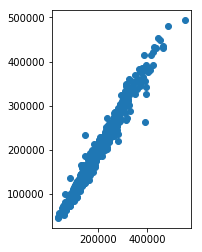

In [158]:
plt.subplots_adjust(wspace=0.4)
plt.subplot(121)
plt.scatter(np.exp(train_y),np.exp(lightgbm.predict(train_x)))

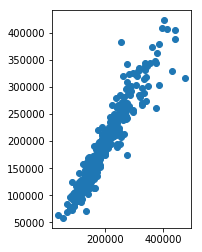

In [159]:
plt.subplots_adjust(wspace=0.4)
plt.subplot(121)
plt.scatter(np.exp(valid_y),np.exp(lightgbm.predict(valid_x)))

## 提出用ファイルの作成

In [168]:
dtest = xgb.DMatrix(test_x)
my_submission = pd.DataFrame()
my_submission["Id"] = test_ID
my_submission["SalePrice"] = np.exp(bst.predict(dtest))
# you could use any filename. We choose submission here
my_submission.to_csv('submission.csv', index=False)

In [50]:
my_submission

,Id
0,1461
1,1462
2,1463
3,1464
4,1465
5,1466
6,1467
7,1468
8,1469
9,1470
